In [1]:
import kagglehub

# Download latest version
EXTRACT_PATH = kagglehub.dataset_download("briscdataset/brisc2025")

print("Path to dataset files:", EXTRACT_PATH)

!pip install -q torch torchvision torchaudio
!pip install -q albumentations kagglehub segmentation-models-pytorch
!pip install -q opencv-python-headless
!pip install -q matplotlib seaborn scikit-learn tqdm
from google.colab import drive
import zipfile
import os

DATA_PATH = EXTRACT_PATH

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import glob
from pathlib import Path
import json
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

Path to dataset files: /kaggle/input/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.9 MB/s

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
NUM_CLASSES = 4

CLASS_NAMES = ['glioma', 'meningioma', 'pituitary', 'no_tumor']
class_to_idx = {name: idx for idx, name in enumerate(CLASS_NAMES)}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

print(f"Class mapping: {class_to_idx}")
print(f"Class mapping: {class_to_idx}")

Class mapping: {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'no_tumor': 3}
Class mapping: {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'no_tumor': 3}


Exploring dataset at: /kaggle/input/

Dataset Structure:
/
brisc2025/
  segmentation_task/
    test/
      images/
        Images: 860
      masks/
        Images: 860
    train/
      images/
        Images: 3933
      masks/
        Images: 3933
  classification_task/
    test/
      pituitary/
        Images: 300
      no_tumor/
        Images: 140
      meningioma/
        Images: 306
      glioma/
        Images: 254
    train/
      pituitary/
        Images: 1457
      no_tumor/
        Images: 1067
      meningioma/
        Images: 1329
      glioma/
        Images: 1147

Total image files found: 15586

Class distribution:
  glioma: 1401 images
  meningioma: 1635 images
  pituitary: 1757 images
  no_tumor: 1207 images


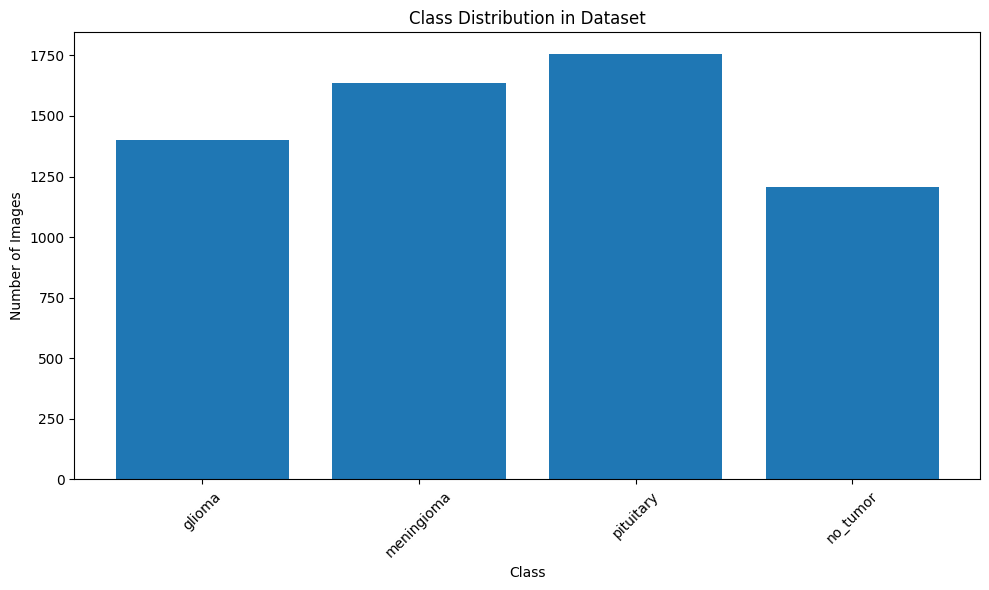

In [5]:
def explore_dataset_structure(data_path):
    print(f"Exploring dataset at: {data_path}")

    if not os.path.exists(data_path):
        print(f"Dataset path {data_path} does not exist.")
        return {}

    print("\nDataset Structure:")
    total_files = 0
    class_counts = {name: 0 for name in CLASS_NAMES}

    for root, dirs, files in os.walk(data_path):
        level = root.replace(data_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")

        subindent = ' ' * 2 * (level + 1)
        image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]

        if image_files:
            print(f"{subindent}Images: {len(image_files)}")
            total_files += len(image_files)

            dir_name = os.path.basename(root).lower()

            for class_name in CLASS_NAMES:
                if class_name.lower() in dir_name:
                    class_counts[class_name] += len([f for f in image_files if '_mask' not in f.lower()])
                    break
            else:
                for file in image_files:
                    if '_mask' not in file.lower():
                        for class_name in CLASS_NAMES:
                            if class_name.lower() in file.lower():
                                class_counts[class_name] += 1
                                break

    print(f"\nTotal image files found: {total_files}")
    print("\nClass distribution:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} images")

    if sum(class_counts.values()) > 0:
        plt.figure(figsize=(10, 6))
        plt.bar(class_counts.keys(), class_counts.values())
        plt.title('Class Distribution in Dataset')
        plt.xlabel('Class')
        plt.ylabel('Number of Images')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return class_counts

class_distribution = explore_dataset_structure(DATA_PATH)

In [6]:
class BrainTumorDataset(Dataset):
    def __init__(self, data_path, image_size=256, transform=None, mode='train'):
        self.data_path = data_path
        self.image_size = image_size
        self.transform = transform
        self.mode = mode

        self.samples = self._load_samples()
        print(f"Loaded {len(self.samples)} samples for {mode} mode")

    def _load_samples(self):
        samples = []
        class_dirs = {}
        for class_name in CLASS_NAMES:
            potential_dirs = [
                os.path.join(self.data_path, class_name),
                os.path.join(self.data_path, class_name.capitalize()),
                os.path.join(self.data_path, class_name.upper())
            ]

            for potential_dir in potential_dirs:
                if os.path.exists(potential_dir) and os.path.isdir(potential_dir):
                    class_dirs[class_name] = potential_dir
                    break

        if class_dirs:
            print(f"Found class directories: {list(class_dirs.keys())}")
            for class_name, class_dir in class_dirs.items():
                image_files = []
                for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']:
                    image_files.extend(glob.glob(os.path.join(class_dir, ext)))
                    image_files.extend(glob.glob(os.path.join(class_dir, ext.upper())))

                for img_path in image_files:
                    if '_mask' not in os.path.basename(img_path).lower():
                        mask_path = self._find_mask(img_path)
                        samples.append({
                            'image_path': img_path,
                            'mask_path': mask_path,
                            'label': class_to_idx[class_name],
                            'class_name': class_name
                        })
        else:
            print("No class directories found, searching in root directory...")
            image_files = []
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']:
                image_files.extend(glob.glob(os.path.join(self.data_path, ext)))
                image_files.extend(glob.glob(os.path.join(self.data_path, ext.upper())))
                image_files.extend(glob.glob(os.path.join(self.data_path, '**', ext), recursive=True))
                image_files.extend(glob.glob(os.path.join(self.data_path, '**', ext.upper()), recursive=True))

            print(f"Found {len(image_files)} potential image files")

            for img_path in image_files:
                if '_mask' not in os.path.basename(img_path).lower():
                    class_name = self._determine_class(img_path)
                    if class_name:
                        mask_path = self._find_mask(img_path)
                        samples.append({
                            'image_path': img_path,
                            'mask_path': mask_path,
                            'label': class_to_idx[class_name],
                            'class_name': class_name
                        })

        if len(samples) == 0:
            print("No real data found, creating synthetic samples for testing...")
            samples = self._create_synthetic_samples()

        return samples

    def _determine_class(self, img_path):
        path_lower = img_path.lower()
        filename = os.path.basename(path_lower)
        dirname = os.path.dirname(path_lower)

        for class_name in CLASS_NAMES:
            class_lower = class_name.lower()
            if (filename.startswith(class_lower) or
                class_lower in filename or
                class_lower in dirname):
                return class_name

        return None

    def _find_mask(self, img_path):
        """Find corresponding mask file"""
        base_name = os.path.splitext(img_path)[0]
        dir_name = os.path.dirname(img_path)
        filename = os.path.splitext(os.path.basename(img_path))[0]

        mask_patterns = [
            base_name + '_mask.png',
            base_name + '_mask.jpg',
            base_name + '_mask.jpeg',
            base_name + '_seg.png',
            base_name + '_segmentation.png',
            os.path.join(dir_name, 'masks', filename + '.png'),
            os.path.join(dir_name, 'masks', filename + '_mask.png'),
        ]

        for pattern in mask_patterns:
            if os.path.exists(pattern):
                return pattern

        return None

    def _create_synthetic_samples(self):
        print("Creating synthetic dataset for testing...")
        samples = []

        for class_idx, class_name in enumerate(CLASS_NAMES):
            for i in range(25):
                samples.append({
                    'image_path': f'synthetic_{class_name}_{i}.jpg',
                    'mask_path': None,
                    'label': class_idx,
                    'class_name': class_name,
                    'synthetic': True
                })

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        if sample.get('synthetic', False):
            image = self._create_synthetic_image(sample['class_name'])
            mask = self._create_synthetic_mask(sample['class_name'])
        else:
            try:
                image = cv2.imread(sample['image_path'])
                if image is None:
                    image = np.array(Image.open(sample['image_path']).convert('RGB'))
                else:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            except Exception as e:
                print(f"Error loading image {sample['image_path']}: {e}")
                image = self._create_synthetic_image(sample['class_name'])

            if sample['mask_path'] and os.path.exists(sample['mask_path']):
                try:
                    mask = cv2.imread(sample['mask_path'], cv2.IMREAD_GRAYSCALE)
                    if mask is None:
                        mask = np.array(Image.open(sample['mask_path']).convert('L'))
                    _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)
                except Exception as e:
                    print(f"Error loading mask {sample['mask_path']}: {e}")
                    mask = self._create_synthetic_mask(sample['class_name'])
            else:
                mask = self._create_synthetic_mask(sample['class_name'])

        image, mask = self._preprocess(image, mask)

        if self.transform:
            if not isinstance(image, np.ndarray):
                image = np.array(image)
            if not isinstance(mask, np.ndarray):
                mask = np.array(mask)

            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).long()
        else:
            mask = mask.long()

        label = torch.tensor(sample['label'], dtype=torch.long)

        return {
            'image': image,
            'mask': mask,
            'label': label,
            'class_name': sample['class_name']
        }

    def _create_synthetic_image(self, class_name):
        image = np.zeros((256, 256, 3), dtype=np.uint8)

        center = (128, 128)
        axes = (80, 100)
        cv2.ellipse(image, center, axes, 0, 0, 360, (100, 100, 100), -1)

        cv2.ellipse(image, (100, 120), (30, 40), 0, 0, 360, (150, 150, 150), -1)
        cv2.ellipse(image, (156, 120), (30, 40), 0, 0, 360, (150, 150, 150), -1)

        if class_name != 'no_tumor':
            if class_name == 'glioma':
                cv2.circle(image, (120, 110), 15, (200, 100, 100), -1)
            elif class_name == 'meningioma':
                cv2.circle(image, (140, 130), 12, (100, 200, 100), -1)
            elif class_name == 'pituitary':
                cv2.circle(image, (128, 140), 8, (100, 100, 200), -1)

        noise = np.random.normal(0, 20, image.shape).astype(np.uint8)
        image = cv2.add(image, noise)

        return image

    def _create_synthetic_mask(self, class_name):
        mask = np.zeros((256, 256), dtype=np.uint8)

        if class_name != 'no_tumor':
            if class_name == 'glioma':
                cv2.circle(mask, (120, 110), 15, 1, -1)
            elif class_name == 'meningioma':
                cv2.circle(mask, (140, 130), 12, 1, -1)
            elif class_name == 'pituitary':
                cv2.circle(mask, (128, 140), 8, 1, -1)

        return mask

    def _preprocess(self, image, mask):
        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)

        image = cv2.bilateralFilter(image, 9, 75, 75)

        if np.max(mask) > 0:
            kernel = np.ones((3, 3), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

        return image, mask

In [7]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(var_limit=(10, 50), p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [8]:
def create_data_loaders(data_path, batch_size=16, val_split=0.2, test_split=0.1):
    try:
        full_dataset = BrainTumorDataset(data_path, transform=None)

        if len(full_dataset) == 0:
            raise ValueError("Dataset is empty. Check your data path and files.")

        total_size = len(full_dataset)
        test_size = int(test_split * total_size)
        val_size = int(val_split * total_size)
        train_size = total_size - val_size - test_size

        if train_size <= 0:
            train_size = max(1, total_size - 2)
            val_size = 1
            test_size = 1

        print(f"Dataset splits - Train: {train_size}, Val: {val_size}, Test: {test_size}")

        train_dataset, val_dataset, test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42)
        )

        train_data = BrainTumorDataset(data_path, transform=train_transform, mode='train')
        val_data = BrainTumorDataset(data_path, transform=val_transform, mode='val')
        test_data = BrainTumorDataset(data_path, transform=val_transform, mode='test')

        train_indices = train_dataset.indices
        val_indices = val_dataset.indices
        test_indices = test_dataset.indices

        train_dataset = Subset(train_data, train_indices)
        val_dataset = Subset(val_data, val_indices)
        test_dataset = Subset(test_data, test_indices)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

        return train_loader, val_loader, test_loader

    except Exception as e:
        print(f"Error creating data loaders: {e}")
        return create_minimal_loaders(batch_size)

def create_minimal_loaders(batch_size):
    dataset = BrainTumorDataset("/tmp", transform=val_transform)
    loader = DataLoader(dataset, batch_size=min(batch_size, 4), shuffle=True)
    return loader, loader, loader

try:
    train_loader, val_loader, test_loader = create_data_loaders(DATA_PATH, BATCH_SIZE)
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")
except Exception as e:
    print(f"Error creating data loaders: {e}")
    print("Creating minimal dataset for demonstration...")
    train_loader, val_loader, test_loader = create_minimal_loaders(BATCH_SIZE)

No class directories found, searching in root directory...
Found 15586 potential image files
Loaded 6000 samples for train mode
Dataset splits - Train: 4200, Val: 1200, Test: 600
No class directories found, searching in root directory...
Found 15586 potential image files
Loaded 6000 samples for train mode
No class directories found, searching in root directory...
Found 15586 potential image files
Loaded 6000 samples for val mode
No class directories found, searching in root directory...
Found 15586 potential image files
Loaded 6000 samples for test mode
Train batches: 263
Val batches: 75
Test batches: 38


In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, n_classification_classes=4, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.n_classification_classes = n_classification_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(1024 // factor, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, n_classification_classes)
        )

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        classification_features = self.global_avg_pool(x5)
        classification_features = classification_features.view(classification_features.size(0), -1)
        classification_output = self.classifier(classification_features)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        segmentation_output = self.outc(x)

        return segmentation_output, classification_output

In [11]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)

        return x * psi

class AttentionUp(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(AttentionUp, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

        self.attention = AttentionBlock(F_g=in_channels//2, F_l=in_channels//2, F_int=in_channels//4)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x2 = self.attention(g=x1, x=x2)

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [12]:
class AttentionUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, n_classification_classes=4, bilinear=True):
        super(AttentionUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.n_classification_classes = n_classification_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        self.up1 = AttentionUp(1024, 512 // factor, bilinear)
        self.up2 = AttentionUp(512, 256 // factor, bilinear)
        self.up3 = AttentionUp(256, 128 // factor, bilinear)
        self.up4 = AttentionUp(128, 64, bilinear)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(1024 // factor, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, n_classification_classes)
        )

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        classification_features = self.global_avg_pool(x5)
        classification_features = classification_features.view(classification_features.size(0), -1)
        classification_output = self.classifier(classification_features)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        segmentation_output = self.outc(x)

        return segmentation_output, classification_output

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, prediction, target):
        prediction = torch.sigmoid(prediction)

        prediction = prediction.view(-1)
        target = target.view(-1)

        intersection = (prediction * target).sum()
        dice = (2. * intersection + self.smooth) / (prediction.sum() + target.sum() + self.smooth)

        return 1 - dice

In [14]:
class CombinedLoss(nn.Module):
    def __init__(self, seg_weight=1.0, cls_weight=1.0):
        super(CombinedLoss, self).__init__()
        self.seg_weight = seg_weight
        self.cls_weight = cls_weight
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss()
        self.seg_ce_loss = nn.CrossEntropyLoss()

    def forward(self, seg_pred, cls_pred, seg_target, cls_target):
        seg_target = seg_target.long()
        cls_target = cls_target.long()

        dice_loss = self.dice_loss(seg_pred[:, 1:], seg_target.float())
        seg_ce_loss = self.seg_ce_loss(seg_pred, seg_target)
        seg_loss = dice_loss + seg_ce_loss

        cls_loss = self.ce_loss(cls_pred, cls_target)

        total_loss = self.seg_weight * seg_loss + self.cls_weight * cls_loss

        return total_loss, seg_loss, cls_loss


In [15]:
def calculate_iou(pred, target, num_classes=2):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().data.cpu().item()
        union = pred_inds.long().sum().data.cpu().item() + target_inds.long().sum().data.cpu().item() - intersection
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(float(intersection) / float(max(union, 1)))
    return ious

def calculate_dice_coefficient(pred, target):
    smooth = 1.
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice.item()

def calculate_pixel_accuracy(pred, target):
    correct = (pred == target).float().sum()
    total = target.numel()
    return (correct / total).item()


In [16]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_seg_loss = 0.0
    running_cls_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_pixel_acc = 0.0
    running_cls_acc = 0.0

    progress_bar = tqdm(dataloader, desc="Training")

    for batch_idx, batch in enumerate(progress_bar):
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        seg_pred, cls_pred = model(images)

        total_loss, seg_loss, cls_loss = criterion(seg_pred, cls_pred, masks, labels)

        total_loss.backward()
        optimizer.step()

        with torch.no_grad():
            seg_pred_binary = torch.argmax(seg_pred, dim=1)
            dice = calculate_dice_coefficient(seg_pred_binary.float(), masks.float())
            iou = calculate_iou(seg_pred_binary, masks)
            pixel_acc = calculate_pixel_accuracy(seg_pred_binary, masks)

            cls_pred_labels = torch.argmax(cls_pred, dim=1)
            cls_acc = (cls_pred_labels == labels).float().mean().item()

        running_loss += total_loss.item()
        running_seg_loss += seg_loss.item()
        running_cls_loss += cls_loss.item()
        running_dice += dice
        running_iou += np.nanmean(iou)
        running_pixel_acc += pixel_acc
        running_cls_acc += cls_acc

        progress_bar.set_postfix({
            'Loss': f'{total_loss.item():.4f}',
            'Dice': f'{dice:.4f}',
            'Cls_Acc': f'{cls_acc:.4f}'
        })

    num_batches = len(dataloader)
    return {
        'loss': running_loss / num_batches,
        'seg_loss': running_seg_loss / num_batches,
        'cls_loss': running_cls_loss / num_batches,
        'dice': running_dice / num_batches,
        'iou': running_iou / num_batches,
        'pixel_acc': running_pixel_acc / num_batches,
        'cls_acc': running_cls_acc / num_batches
    }

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_seg_loss = 0.0
    running_cls_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_pixel_acc = 0.0
    running_cls_acc = 0.0

    all_cls_preds = []
    all_cls_targets = []

    progress_bar = tqdm(dataloader, desc="Validation")

    with torch.no_grad():
        for batch_idx, batch in enumerate(progress_bar):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            labels = batch['label'].to(device)

            seg_pred, cls_pred = model(images)

            total_loss, seg_loss, cls_loss = criterion(seg_pred, cls_pred, masks, labels)

            seg_pred_binary = torch.argmax(seg_pred, dim=1)
            dice = calculate_dice_coefficient(seg_pred_binary.float(), masks.float())
            iou = calculate_iou(seg_pred_binary, masks)
            pixel_acc = calculate_pixel_accuracy(seg_pred_binary, masks)

            cls_pred_labels = torch.argmax(cls_pred, dim=1)
            cls_acc = (cls_pred_labels == labels).float().mean().item()

            all_cls_preds.extend(cls_pred_labels.cpu().numpy())
            all_cls_targets.extend(labels.cpu().numpy())

            running_loss += total_loss.item()
            running_seg_loss += seg_loss.item()
            running_cls_loss += cls_loss.item()
            running_dice += dice
            running_iou += np.nanmean(iou)
            running_pixel_acc += pixel_acc
            running_cls_acc += cls_acc

            progress_bar.set_postfix({
                'Loss': f'{total_loss.item():.4f}',
                'Dice': f'{dice:.4f}',
                'Cls_Acc': f'{cls_acc:.4f}'
            })

    num_batches = len(dataloader)

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_cls_targets, all_cls_preds, average='weighted', zero_division=0
    )

    return {
        'loss': running_loss / num_batches,
        'seg_loss': running_seg_loss / num_batches,
        'cls_loss': running_cls_loss / num_batches,
        'dice': running_dice / num_batches,
        'iou': running_iou / num_batches,
        'pixel_acc': running_pixel_acc / num_batches,
        'cls_acc': running_cls_acc / num_batches,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_cls_preds,
        'targets': all_cls_targets
    }

In [17]:
def train_model(model, train_loader, val_loader, num_epochs=2, learning_rate=1e-3):
    criterion = CombinedLoss(seg_weight=1.0, cls_weight=1.0)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    history = {
        'train_loss': [], 'val_loss': [],
        'train_dice': [], 'val_dice': [],
        'train_cls_acc': [], 'val_cls_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }

    best_val_loss = float('inf')
    best_model_state = None

    print(f"Training {model.__class__.__name__} for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)

        val_metrics = validate_epoch(model, val_loader, criterion, device)

        scheduler.step(val_metrics['loss'])

        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            best_model_state = model.state_dict().copy()

        history['train_loss'].append(train_metrics['loss'])
        history['val_loss'].append(val_metrics['loss'])
        history['train_dice'].append(train_metrics['dice'])
        history['val_dice'].append(val_metrics['dice'])
        history['train_cls_acc'].append(train_metrics['cls_acc'])
        history['val_cls_acc'].append(val_metrics['cls_acc'])
        history['val_precision'].append(val_metrics['precision'])
        history['val_recall'].append(val_metrics['recall'])
        history['val_f1'].append(val_metrics['f1'])

        print(f"Train - Loss: {train_metrics['loss']:.4f}, Dice: {train_metrics['dice']:.4f}, Cls_Acc: {train_metrics['cls_acc']:.4f}")
        print(f"Val   - Loss: {val_metrics['loss']:.4f}, Dice: {val_metrics['dice']:.4f}, Cls_Acc: {val_metrics['cls_acc']:.4f}")
        print(f"Val   - Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}, F1: {val_metrics['f1']:.4f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, history

In [18]:
def plot_training_history(history, title="Training History"):
    """Plot training history"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(title, fontsize=16)

    axes[0, 0].plot(history['train_loss'], label='Train Loss')
    axes[0, 0].plot(history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].plot(history['train_dice'], label='Train Dice')
    axes[0, 1].plot(history['val_dice'], label='Val Dice')
    axes[0, 1].set_title('Dice Score')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    axes[0, 2].plot(history['train_cls_acc'], label='Train Cls Acc')
    axes[0, 2].plot(history['val_cls_acc'], label='Val Cls Acc')
    axes[0, 2].set_title('Classification Accuracy')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Accuracy')
    axes[0, 2].legend()
    axes[0, 2].grid(True)

    axes[1, 0].plot(history['val_precision'], label='Val Precision')
    axes[1, 0].set_title('Validation Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    axes[1, 1].plot(history['val_recall'], label='Val Recall')
    axes[1, 1].set_title('Validation Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    axes[1, 2].plot(history['val_f1'], label='Val F1')
    axes[1, 2].set_title('Validation F1 Score')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('F1 Score')
    axes[1, 2].legend()
    axes[1, 2].grid(True)

    plt.tight_layout()
    plt.show()

BRAIN TUMOR MRI CLASSIFICATION AND SEGMENTATION

Visualizing sample batch...


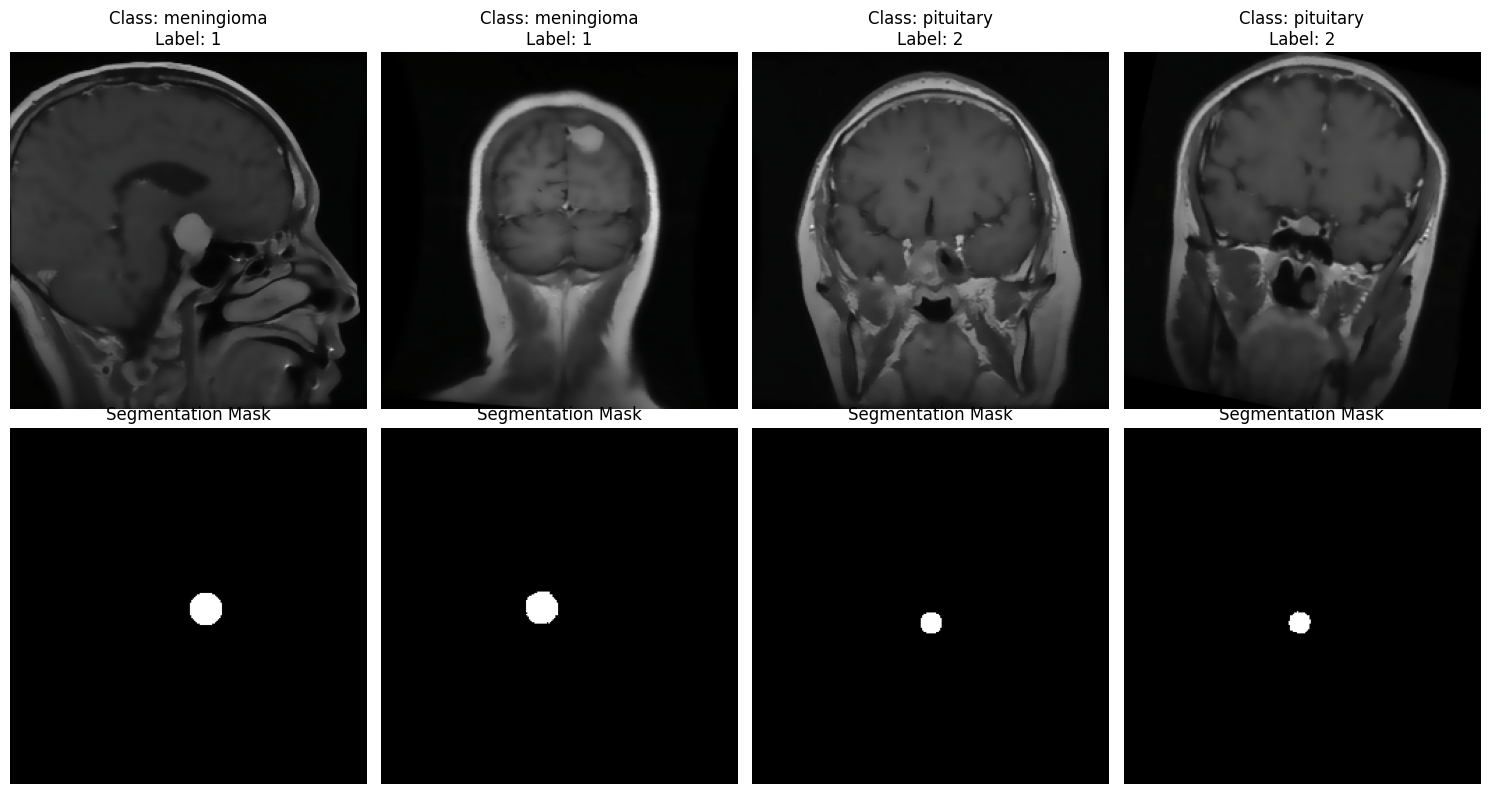


Initializing models...
U-Net parameters: 13,527,750
Attention U-Net parameters: 13,879,282

Training U-Net Model
Training UNet for 2 epochs...

Epoch 1/2
Learning Rate: 0.001000


Validation: 100%|██████████| 75/75 [00:19<00:00,  3.82it/s, Loss=2.0009, Dice=0.0002, Cls_Acc=0.5625]


Train - Loss: 2.3271, Dice: 0.0005, Cls_Acc: 0.4282
Val   - Loss: 2.2285, Dice: 0.0002, Cls_Acc: 0.3858
Val   - Precision: 0.5327, Recall: 0.3858, F1: 0.2665

Epoch 2/2
Learning Rate: 0.001000


Validation: 100%|██████████| 75/75 [00:17<00:00,  4.31it/s, Loss=1.8525, Dice=0.0002, Cls_Acc=0.6250]


Train - Loss: 2.1237, Dice: 0.0002, Cls_Acc: 0.4898
Val   - Loss: 2.0926, Dice: 0.0002, Cls_Acc: 0.5333
Val   - Precision: 0.6295, Recall: 0.5333, F1: 0.4649


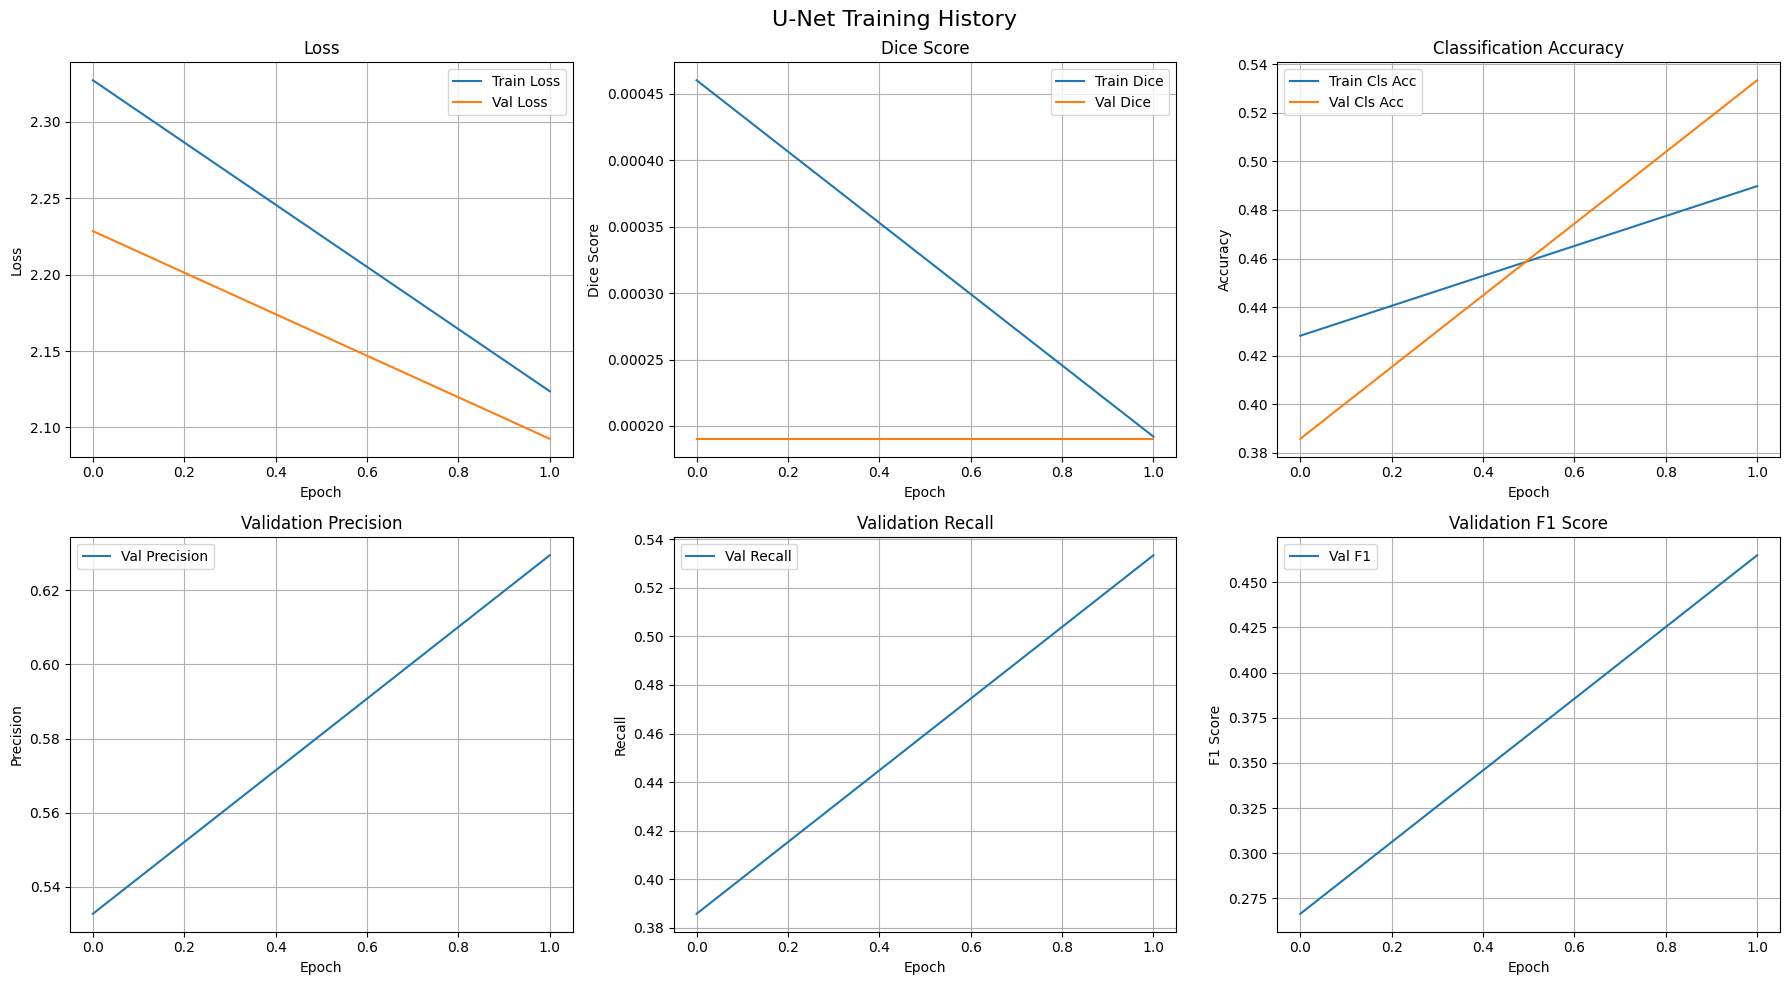


U-Net Evaluation:


Evaluating: 100%|██████████| 38/38 [00:10<00:00,  3.79it/s]


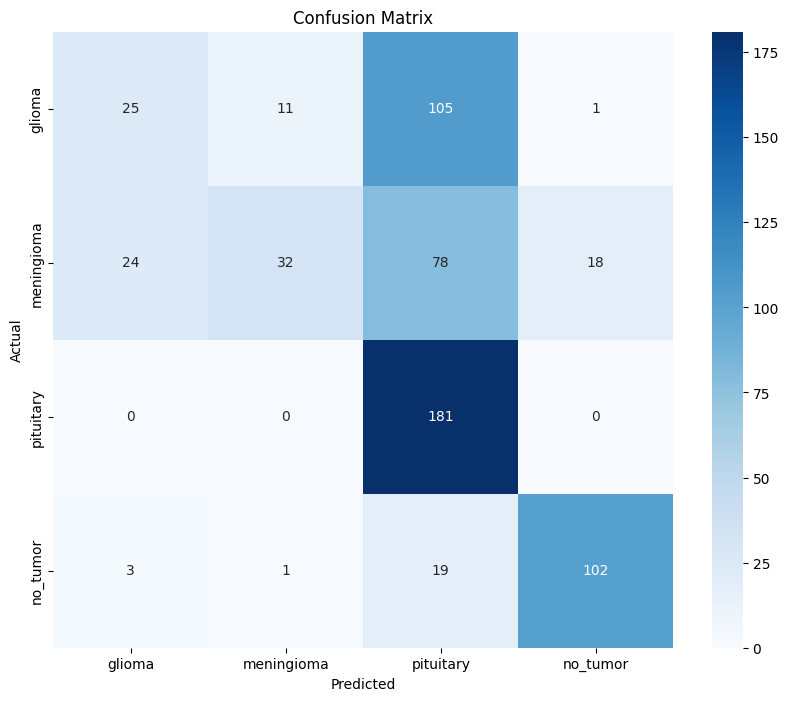

Classification Report:
              precision    recall  f1-score   support

      glioma       0.48      0.18      0.26       142
  meningioma       0.73      0.21      0.33       152
   pituitary       0.47      1.00      0.64       181
    no_tumor       0.84      0.82      0.83       125

    accuracy                           0.57       600
   macro avg       0.63      0.55      0.51       600
weighted avg       0.62      0.57      0.51       600

Segmentation Results:
  Dice Coefficient: 0.2108
  mIoU: 0.6016
  Pixel Accuracy: 0.9949

Classification Results:
  Accuracy: 0.5667
  Precision: 0.6162
  Recall: 0.5667
  F1 Score: 0.5101

U-Net Predictions:


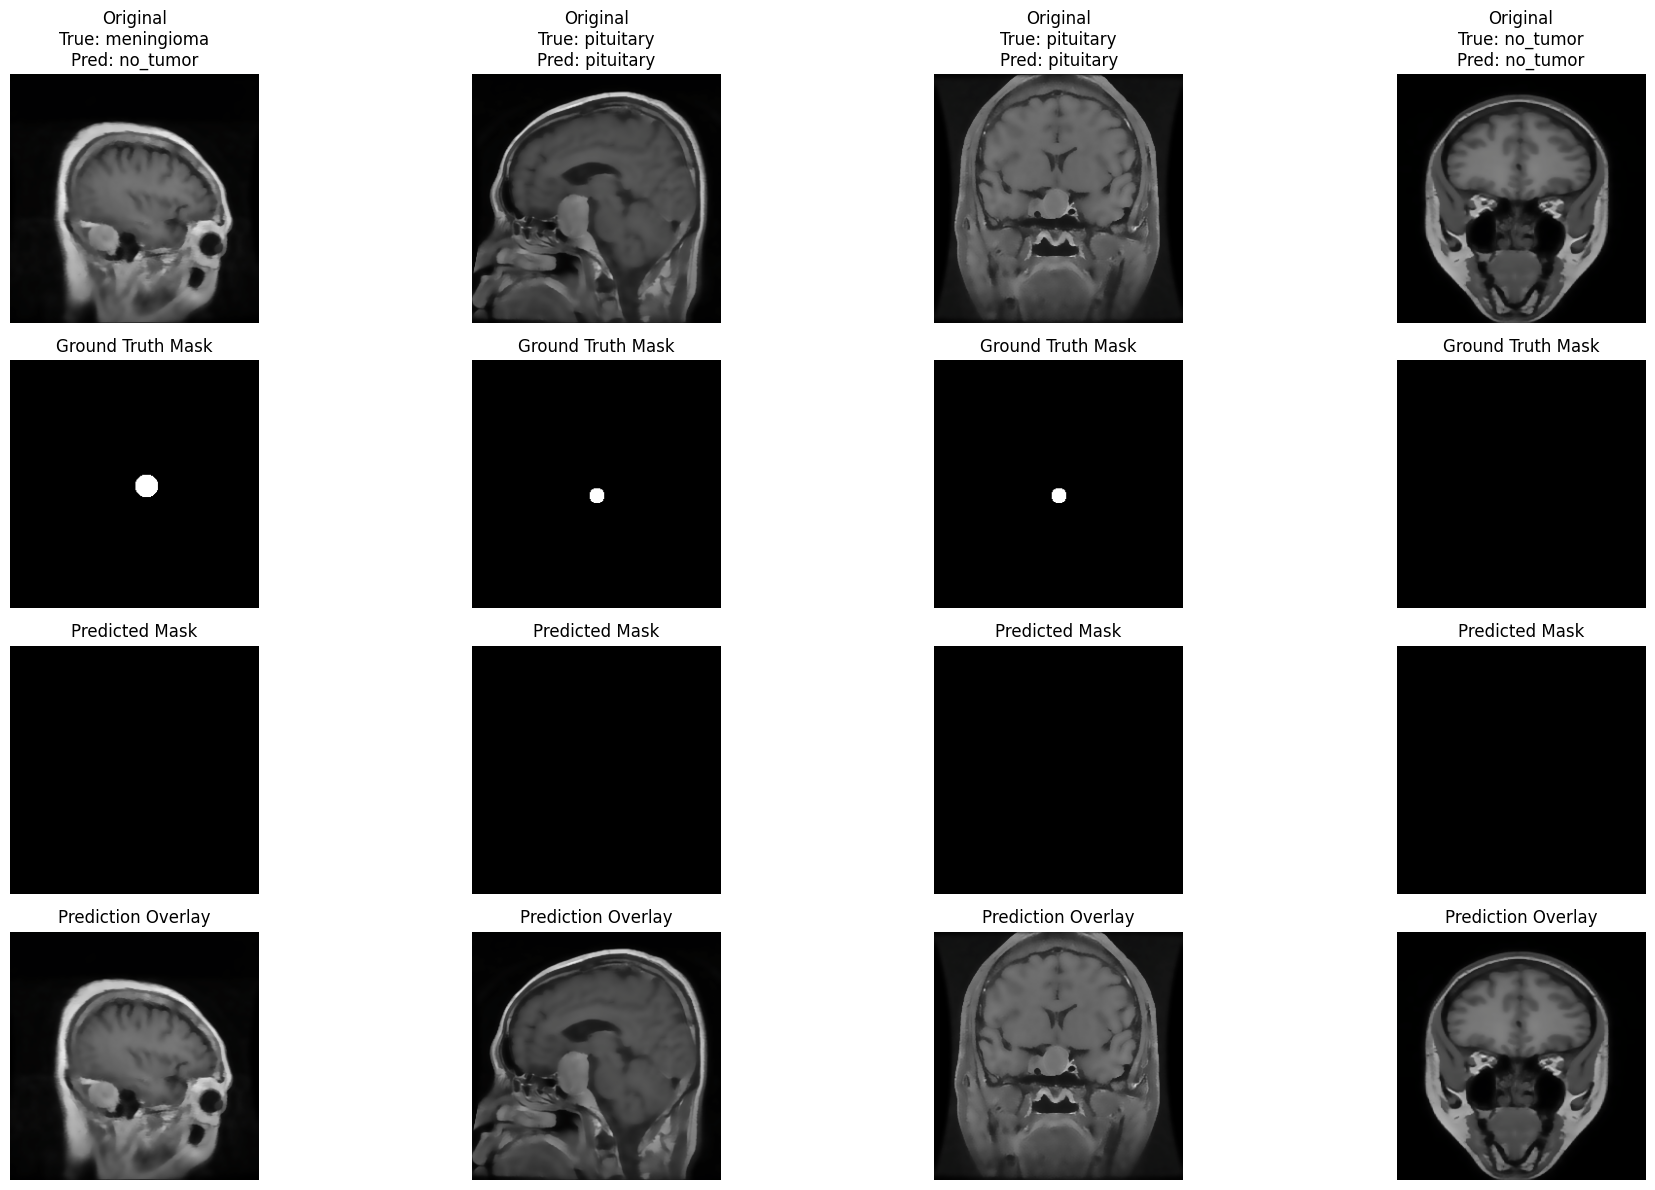


Training Attention U-Net Model
Training AttentionUNet for 2 epochs...

Epoch 1/2
Learning Rate: 0.001000


Validation: 100%|██████████| 75/75 [00:19<00:00,  3.77it/s, Loss=1.9375, Dice=0.0002, Cls_Acc=0.5000]


Train - Loss: 2.2863, Dice: 0.0008, Cls_Acc: 0.4437
Val   - Loss: 2.1429, Dice: 0.0002, Cls_Acc: 0.4783
Val   - Precision: 0.5185, Recall: 0.4783, F1: 0.4007

Epoch 2/2
Learning Rate: 0.001000


Validation: 100%|██████████| 75/75 [00:19<00:00,  3.78it/s, Loss=1.7365, Dice=0.0002, Cls_Acc=0.8125]


Train - Loss: 2.1301, Dice: 0.0002, Cls_Acc: 0.4929
Val   - Loss: 1.9090, Dice: 0.0002, Cls_Acc: 0.6075
Val   - Precision: 0.6437, Recall: 0.6075, F1: 0.5689


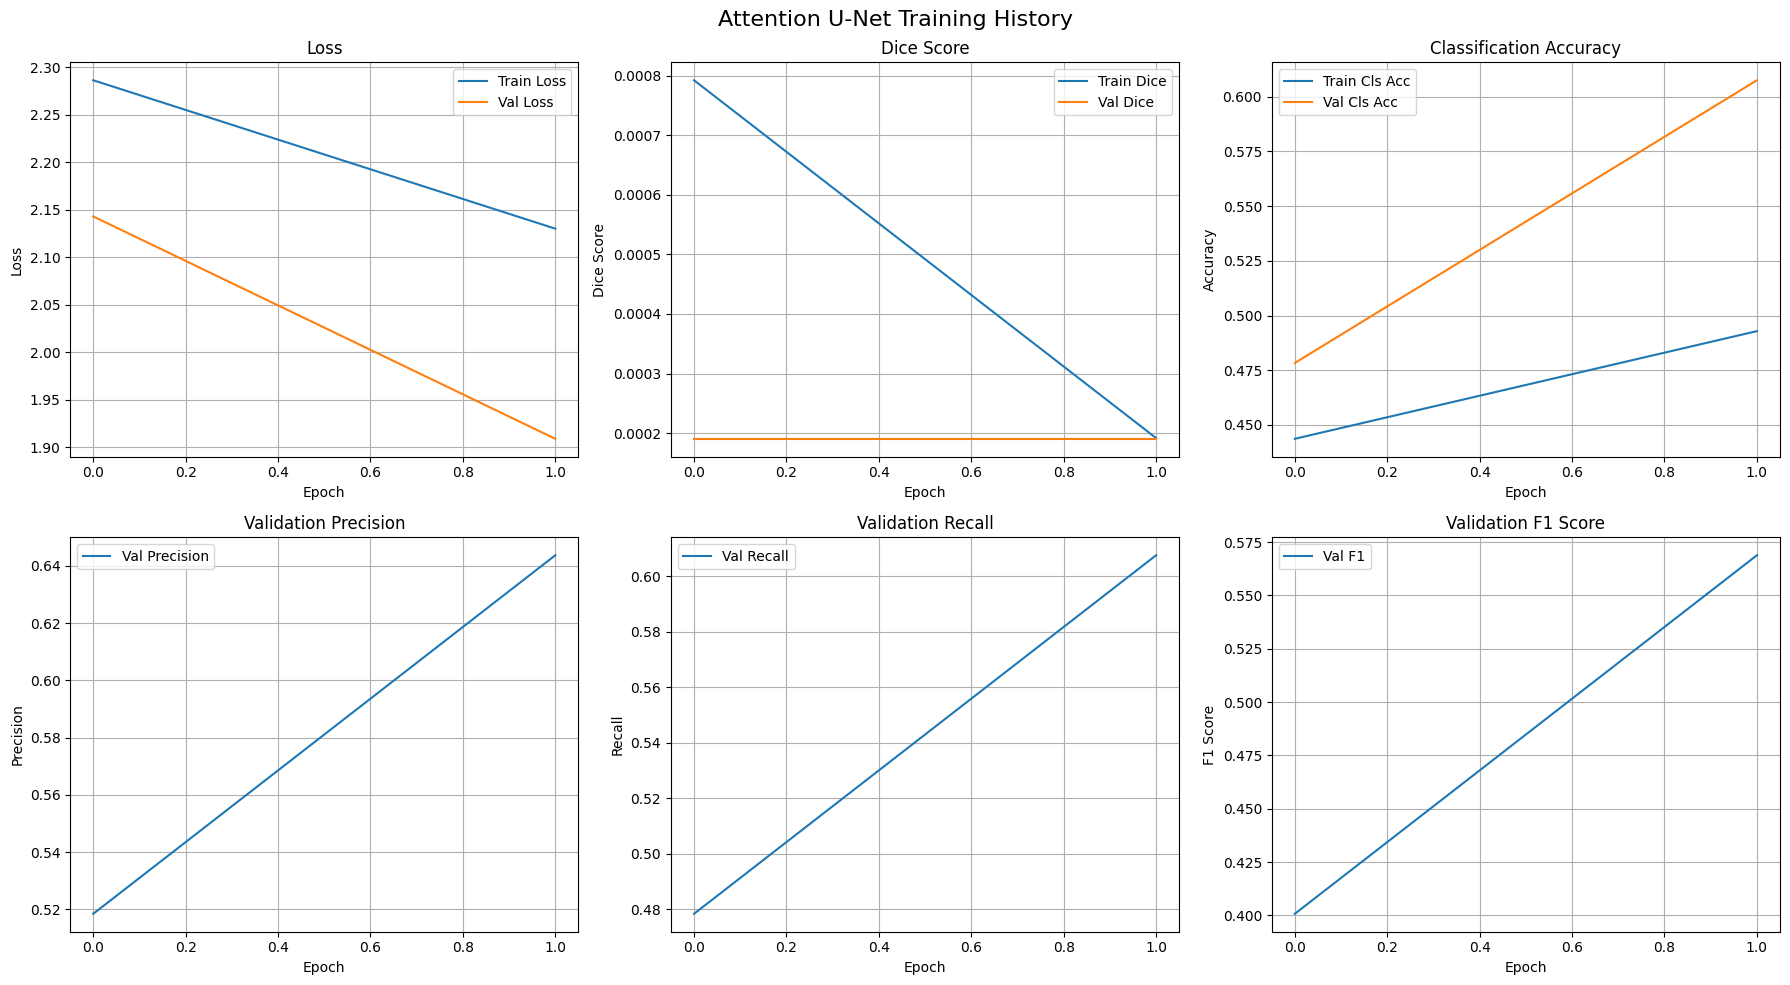


Attention U-Net Evaluation:


Evaluating: 100%|██████████| 38/38 [00:10<00:00,  3.52it/s]


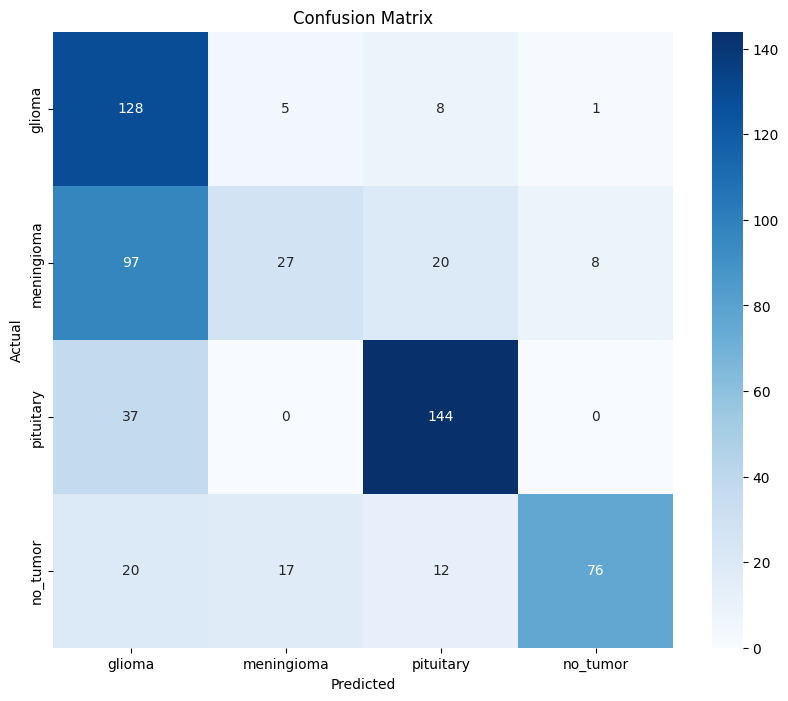

Classification Report:
              precision    recall  f1-score   support

      glioma       0.45      0.90      0.60       142
  meningioma       0.55      0.18      0.27       152
   pituitary       0.78      0.80      0.79       181
    no_tumor       0.89      0.61      0.72       125

    accuracy                           0.62       600
   macro avg       0.67      0.62      0.60       600
weighted avg       0.67      0.62      0.60       600

Segmentation Results:
  Dice Coefficient: 0.2108
  mIoU: 0.6016
  Pixel Accuracy: 0.9949

Classification Results:
  Accuracy: 0.6250
  Precision: 0.6694
  Recall: 0.6250
  F1 Score: 0.5998

Attention U-Net Predictions:


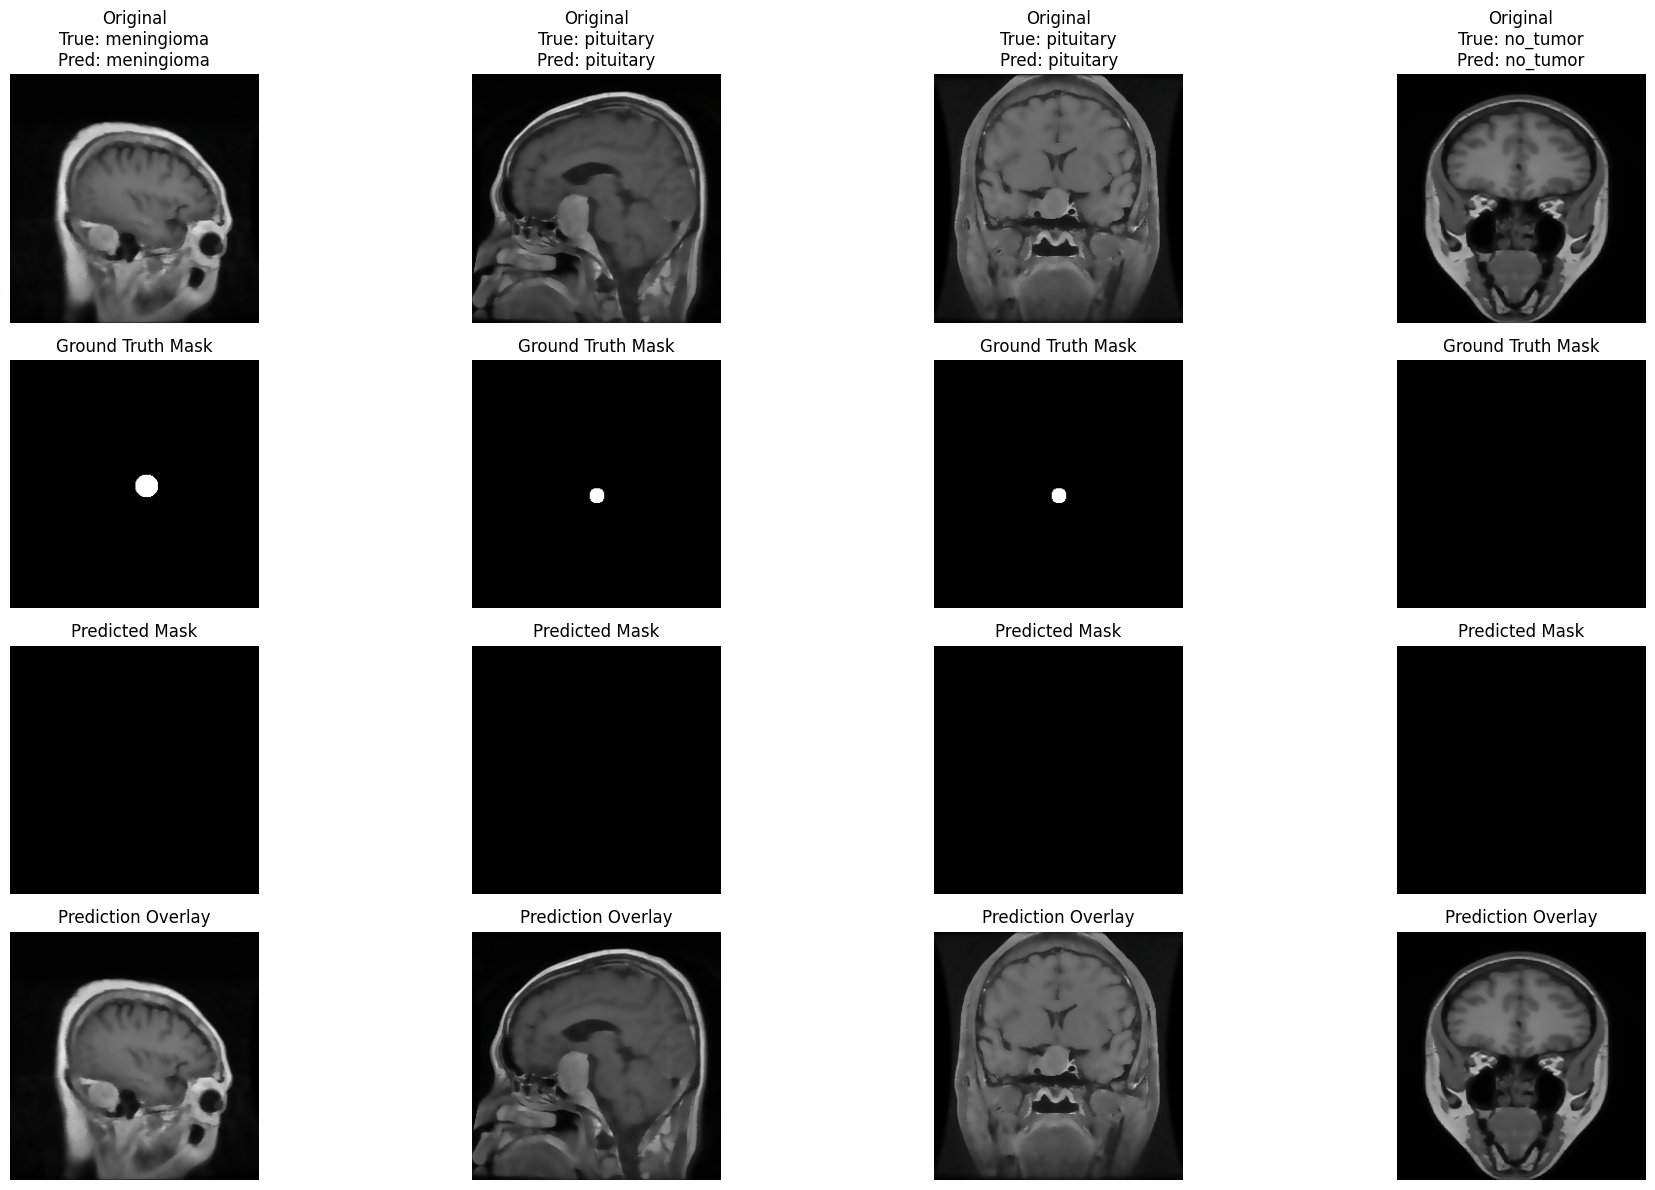


Model Comparison
          Model  Dice Coefficient      IoU  Pixel Accuracy  Classification Accuracy  F1 Score
          U-Net          0.210802 0.601605        0.994876                 0.566667  0.510105
Attention U-Net          0.210802 0.601605        0.994876                 0.625000  0.599774


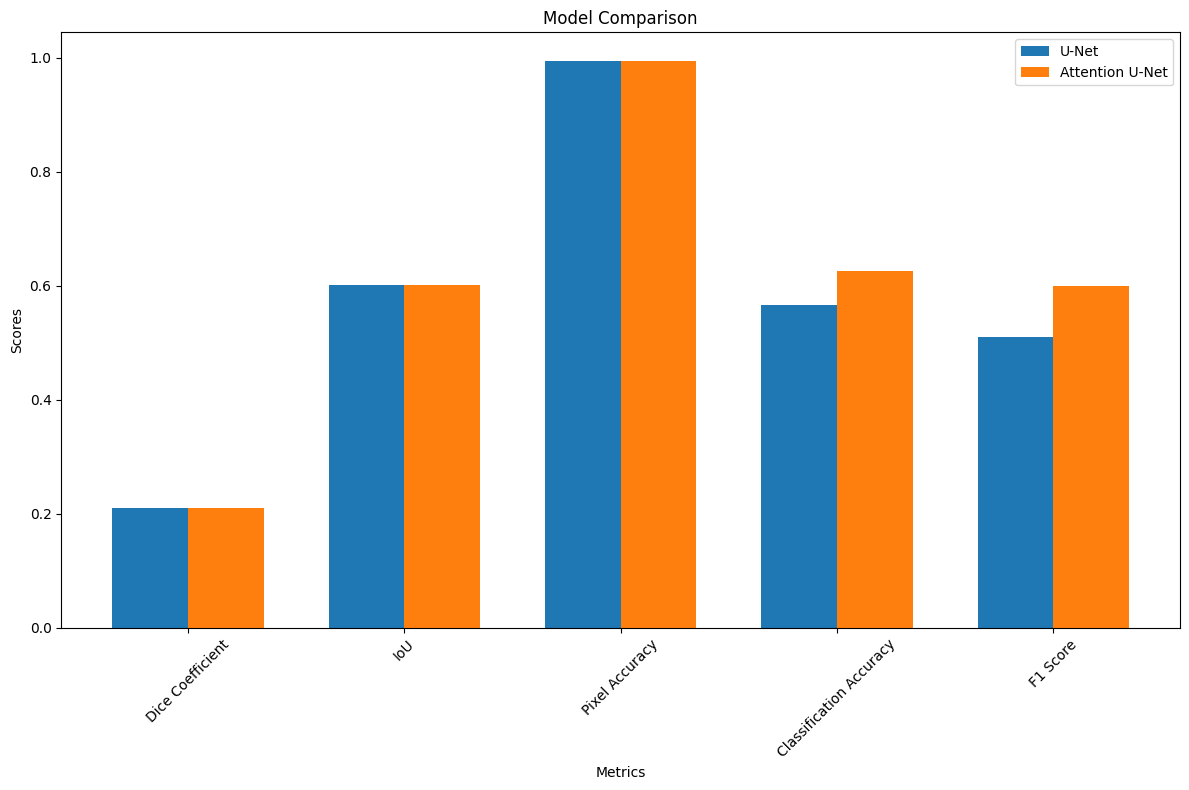

U-Net model saved successfully!
Attention U-Net model saved successfully!

Project execution completed!


In [19]:
def visualize_sample_batch(data_loader):
    try:
        batch = next(iter(data_loader))
        images = batch['image']
        masks = batch['mask']
        labels = batch['label']
        class_names = batch['class_name']

        fig, axes = plt.subplots(2, 4, figsize=(15, 8))

        for i in range(min(4, len(images))):
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image = images[i] * std + mean
            image = torch.clamp(image, 0, 1)

            axes[0, i].imshow(image.permute(1, 2, 0))
            axes[0, i].set_title(f'Class: {class_names[i]}\nLabel: {labels[i].item()}')
            axes[0, i].axis('off')

            axes[1, i].imshow(masks[i], cmap='gray')
            axes[1, i].set_title('Segmentation Mask')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error visualizing batch: {e}")

def visualize_predictions(model, dataloader, device, num_samples=4):
    try:
        model.eval()

        batch = next(iter(dataloader))
        images = batch['image'][:num_samples].to(device)
        masks = batch['mask'][:num_samples]
        labels = batch['label'][:num_samples]
        class_names = [batch['class_name'][i] for i in range(min(num_samples, len(batch['class_name'])))]

        with torch.no_grad():
            seg_pred, cls_pred = model(images)
            seg_pred = torch.argmax(seg_pred, dim=1).cpu()
            cls_pred = torch.argmax(cls_pred, dim=1).cpu()

        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        images_denorm = images.cpu() * std + mean
        images_denorm = torch.clamp(images_denorm, 0, 1)

        fig, axes = plt.subplots(4, num_samples, figsize=(20, 12))

        for i in range(num_samples):
            axes[0, i].imshow(images_denorm[i].permute(1, 2, 0))
            axes[0, i].set_title(f'Original\nTrue: {class_names[i]}\nPred: {CLASS_NAMES[cls_pred[i]]}')
            axes[0, i].axis('off')

            axes[1, i].imshow(masks[i], cmap='gray')
            axes[1, i].set_title('Ground Truth Mask')
            axes[1, i].axis('off')

            axes[2, i].imshow(seg_pred[i], cmap='gray')
            axes[2, i].set_title('Predicted Mask')
            axes[2, i].axis('off')

            overlay = images_denorm[i].permute(1, 2, 0).numpy()
            mask_overlay = seg_pred[i].numpy()
            overlay_copy = overlay.copy()
            overlay_copy[mask_overlay == 1] = [1, 0, 0]
            axes[3, i].imshow(overlay_copy)
            axes[3, i].set_title('Prediction Overlay')
            axes[3, i].axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error visualizing predictions: {e}")

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix"""
    try:
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        print("Classification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names))
    except Exception as e:
        print(f"Error plotting confusion matrix: {e}")

def evaluate_model(model, test_loader, device):
    model.eval()

    all_seg_dice = []
    all_seg_iou = []
    all_pixel_acc = []
    all_cls_preds = []
    all_cls_targets = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            try:
                images = batch['image'].to(device)
                masks = batch['mask'].to(device)
                labels = batch['label'].to(device)

                seg_pred, cls_pred = model(images)

                seg_pred_binary = torch.argmax(seg_pred, dim=1)

                for i in range(images.shape[0]):
                    dice = calculate_dice_coefficient(seg_pred_binary[i].float(), masks[i].float())
                    iou = calculate_iou(seg_pred_binary[i], masks[i])
                    pixel_acc = calculate_pixel_accuracy(seg_pred_binary[i], masks[i])

                    all_seg_dice.append(dice)
                    all_seg_iou.append(np.nanmean(iou))
                    all_pixel_acc.append(pixel_acc)

                cls_pred_labels = torch.argmax(cls_pred, dim=1)
                all_cls_preds.extend(cls_pred_labels.cpu().numpy())
                all_cls_targets.extend(labels.cpu().numpy())
            except Exception as e:
                print(f"Error in evaluation batch: {e}")
                continue

    if len(all_seg_dice) == 0:
        print("No valid evaluation data")
        return {}

    mean_dice = np.mean(all_seg_dice)
    mean_iou = np.mean(all_seg_iou)
    mean_pixel_acc = np.mean(all_pixel_acc)

    cls_accuracy = accuracy_score(all_cls_targets, all_cls_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_cls_targets, all_cls_preds, average='weighted', zero_division=0
    )

    plot_confusion_matrix(all_cls_targets, all_cls_preds, CLASS_NAMES)

    print(f"Segmentation Results:")
    print(f"  Dice Coefficient: {mean_dice:.4f}")
    print(f"  mIoU: {mean_iou:.4f}")
    print(f"  Pixel Accuracy: {mean_pixel_acc:.4f}")
    print(f"\nClassification Results:")
    print(f"  Accuracy: {cls_accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")

    return {
        'seg_dice': mean_dice,
        'seg_iou': mean_iou,
        'pixel_acc': mean_pixel_acc,
        'cls_accuracy': cls_accuracy,
        'cls_precision': precision,
        'cls_recall': recall,
        'cls_f1': f1
    }

print("="*60)
print("BRAIN TUMOR MRI CLASSIFICATION AND SEGMENTATION")
print("="*60)

print("\nVisualizing sample batch...")
visualize_sample_batch(train_loader)

print("\nInitializing models...")
unet_model = UNet(n_channels=3, n_classes=2, n_classification_classes=4).to(device)
att_unet_model = AttentionUNet(n_channels=3, n_classes=2, n_classification_classes=4).to(device)

print(f"U-Net parameters: {sum(p.numel() for p in unet_model.parameters()):,}")
print(f"Attention U-Net parameters: {sum(p.numel() for p in att_unet_model.parameters()):,}")

print("\n" + "="*50)
print("Training U-Net Model")
print("="*50)
try:
    trained_unet, unet_history = train_model(
        unet_model, train_loader, val_loader, num_epochs=2, learning_rate=1e-3
    )

    plot_training_history(unet_history, "U-Net Training History")

    print("\nU-Net Evaluation:")
    unet_results = evaluate_model(trained_unet, test_loader, device)

    print("\nU-Net Predictions:")
    visualize_predictions(trained_unet, test_loader, device)

except Exception as e:
    print(f"Error training U-Net: {e}")
    unet_results = {}

print("\n" + "="*50)
print("Training Attention U-Net Model")
print("="*50)
try:
    trained_att_unet, att_unet_history = train_model(
        att_unet_model, train_loader, val_loader, num_epochs=2, learning_rate=1e-3
    )

    plot_training_history(att_unet_history, "Attention U-Net Training History")

    print("\nAttention U-Net Evaluation:")
    att_unet_results = evaluate_model(trained_att_unet, test_loader, device)

    print("\nAttention U-Net Predictions:")
    visualize_predictions(trained_att_unet, test_loader, device)

except Exception as e:
    print(f"Error training Attention U-Net: {e}")
    att_unet_results = {}

print("\n" + "="*50)
print("Model Comparison")
print("="*50)

if unet_results and att_unet_results:
    comparison_data = {
        'Model': ['U-Net', 'Attention U-Net'],
        'Dice Coefficient': [unet_results.get('seg_dice', 0), att_unet_results.get('seg_dice', 0)],
        'IoU': [unet_results.get('seg_iou', 0), att_unet_results.get('seg_iou', 0)],
        'Pixel Accuracy': [unet_results.get('pixel_acc', 0), att_unet_results.get('pixel_acc', 0)],
        'Classification Accuracy': [unet_results.get('cls_accuracy', 0), att_unet_results.get('cls_accuracy', 0)],
        'F1 Score': [unet_results.get('cls_f1', 0), att_unet_results.get('cls_f1', 0)]
    }

    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

    metrics = ['Dice Coefficient', 'IoU', 'Pixel Accuracy', 'Classification Accuracy', 'F1 Score']

    unet_values = [unet_results.get('seg_dice', 0), unet_results.get('seg_iou', 0),
                  unet_results.get('pixel_acc', 0), unet_results.get('cls_accuracy', 0),
                  unet_results.get('cls_f1', 0)]

    att_unet_values = [att_unet_results.get('seg_dice', 0), att_unet_results.get('seg_iou', 0),
                      att_unet_results.get('pixel_acc', 0), att_unet_results.get('cls_accuracy', 0),
                      att_unet_results.get('cls_f1', 0)]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.bar(x - width/2, unet_values, width, label='U-Net')
    ax.bar(x + width/2, att_unet_values, width, label='Attention U-Net')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Model Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()

try:
    if 'trained_unet' in locals():
        torch.save(trained_unet.state_dict(), 'unet_brain_tumor_model.pth')
        print("U-Net model saved successfully!")

    if 'trained_att_unet' in locals():
        torch.save(trained_att_unet.state_dict(), 'attention_unet_brain_tumor_model.pth')
        print("Attention U-Net model saved successfully!")

except Exception as e:
    print(f"Error saving models: {e}")

print("\nProject execution completed!")

BONUS TASK 1: Comparing Joint vs Separate Training
Training standard U-Net for comparison...
Training UNet for 2 epochs...

Epoch 1/2
Learning Rate: 0.001000


Validation: 100%|██████████| 75/75 [00:17<00:00,  4.30it/s, Loss=0.9472, Dice=0.0002, Cls_Acc=0.7500]


Train - Loss: 1.4201, Dice: 0.0012, Cls_Acc: 0.4225
Val   - Loss: 1.1245, Dice: 0.0002, Cls_Acc: 0.5175
Val   - Precision: 0.5745, Recall: 0.5175, F1: 0.4637

Epoch 2/2
Learning Rate: 0.001000


Validation: 100%|██████████| 75/75 [00:17<00:00,  4.21it/s, Loss=0.5590, Dice=0.0002, Cls_Acc=0.9375]


Train - Loss: 1.1518, Dice: 0.0002, Cls_Acc: 0.5247
Val   - Loss: 0.8213, Dice: 0.0002, Cls_Acc: 0.7217
Val   - Precision: 0.7279, Recall: 0.7217, F1: 0.7232


Evaluating: 100%|██████████| 38/38 [00:09<00:00,  3.90it/s]


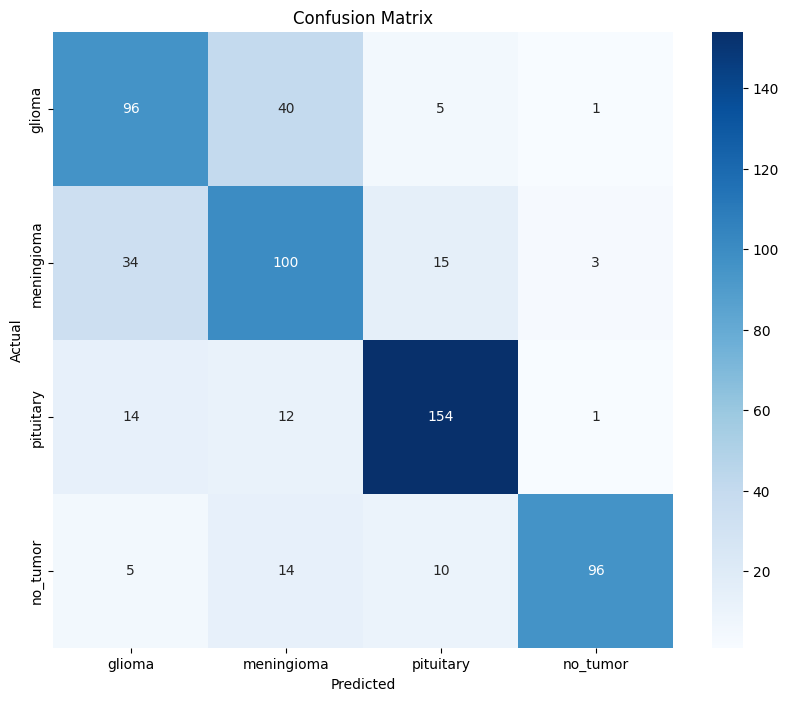

Classification Report:
              precision    recall  f1-score   support

      glioma       0.64      0.68      0.66       142
  meningioma       0.60      0.66      0.63       152
   pituitary       0.84      0.85      0.84       181
    no_tumor       0.95      0.77      0.85       125

    accuracy                           0.74       600
   macro avg       0.76      0.74      0.75       600
weighted avg       0.76      0.74      0.75       600

Segmentation Results:
  Dice Coefficient: 0.2108
  mIoU: 0.6016
  Pixel Accuracy: 0.9949

Classification Results:
  Accuracy: 0.7433
  Precision: 0.7556
  Recall: 0.7433
  F1 Score: 0.7470


Validation: 100%|██████████| 75/75 [00:17<00:00,  4.28it/s]


Epoch 1/2:
Train Loss: 1.0082, Train Acc: 58.21%
Val Loss: 0.7406, Val Acc: 70.75%


Validation: 100%|██████████| 75/75 [00:17<00:00,  4.24it/s]


Epoch 2/2:
Train Loss: 1.0048, Train Acc: 58.38%
Val Loss: 0.7182, Val Acc: 73.50%


Evaluating: 100%|██████████| 38/38 [00:09<00:00,  3.93it/s]


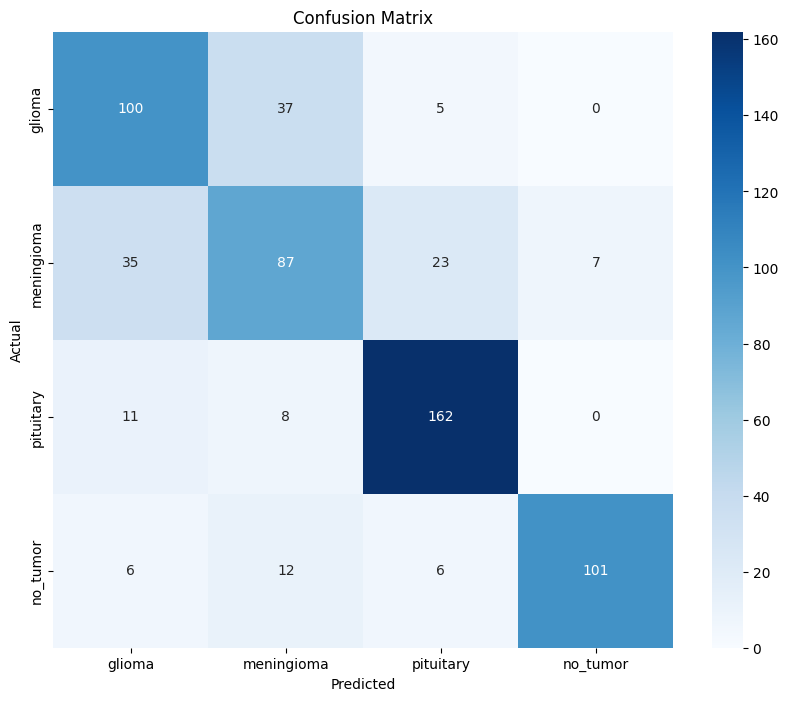

Classification Report:
              precision    recall  f1-score   support

      glioma       0.66      0.70      0.68       142
  meningioma       0.60      0.57      0.59       152
   pituitary       0.83      0.90      0.86       181
    no_tumor       0.94      0.81      0.87       125

    accuracy                           0.75       600
   macro avg       0.76      0.74      0.75       600
weighted avg       0.75      0.75      0.75       600

Segmentation Results:
  Dice Coefficient: 0.2108
  mIoU: 0.6016
  Pixel Accuracy: 0.9949

Classification Results:
  Accuracy: 0.7500
  Precision: 0.7529
  Recall: 0.7500
  F1 Score: 0.7498

Comparison of Joint vs Separate Training:
            Model  Dice Coefficient      IoU  Pixel Accuracy  Classification Accuracy  F1 Score
   Joint Training          0.210802 0.601605        0.994876                 0.743333  0.747029
Separate Training          0.210802 0.601605        0.994876                 0.750000  0.749789


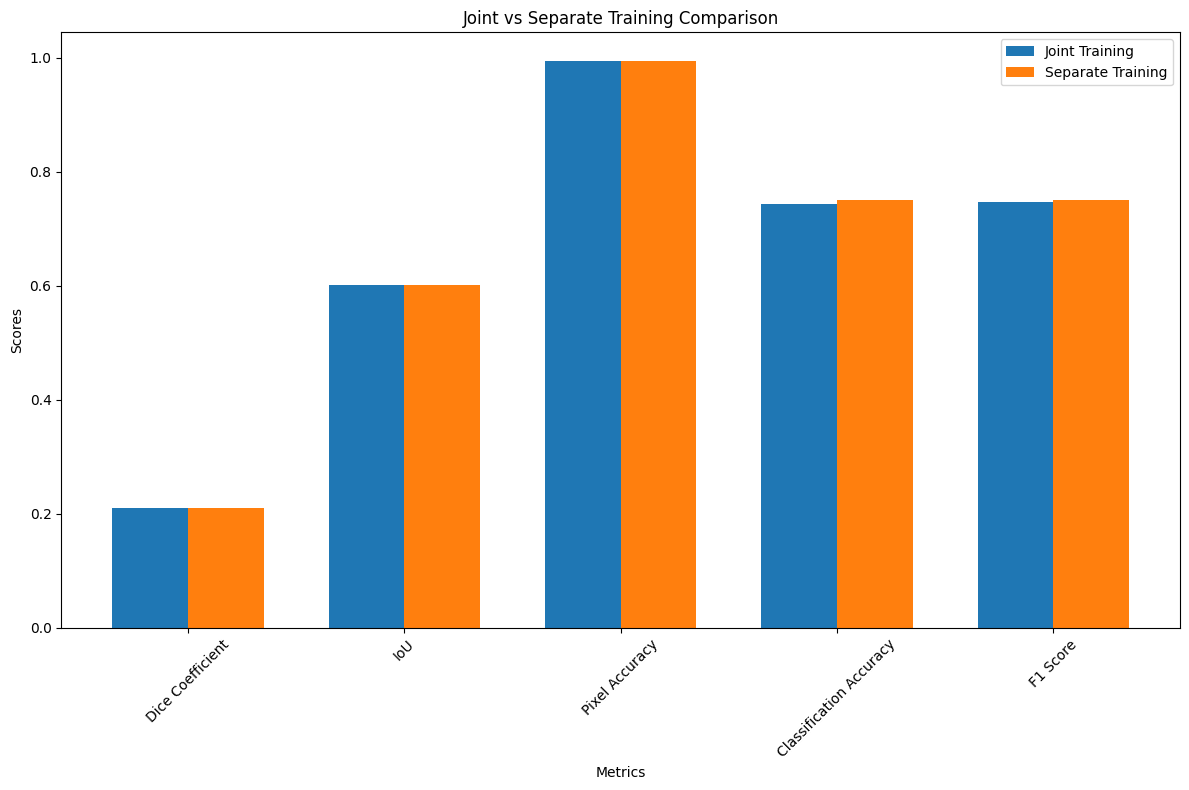

In [24]:
# Add this cell to fix the Dice loss implementation
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, prediction, target):
        if prediction.dim() > target.dim():
            if target.dim() == 3:
                num_classes = prediction.size(1)
                target_onehot = torch.zeros_like(prediction)
                for c in range(num_classes):
                    target_onehot[:, c, :, :] = (target == c).float()
                target = target_onehot
        
        prediction = prediction.contiguous().view(-1)
        target = target.contiguous().view(-1)
        
        intersection = (prediction * target).sum()
        dice = (2. * intersection + self.smooth) / (prediction.sum() + target.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, seg_weight=1.0, cls_weight=1.0):
        super(CombinedLoss, self).__init__()
        self.seg_weight = seg_weight
        self.cls_weight = cls_weight
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss()
        self.seg_ce_loss = nn.CrossEntropyLoss()

    def forward(self, seg_pred, cls_pred, seg_target, cls_target):
        seg_target = seg_target.long()
        cls_target = cls_target.long()

        seg_pred_softmax = F.softmax(seg_pred, dim=1)
        dice_loss = self.dice_loss(seg_pred_softmax, seg_target)
        
        seg_ce_loss = self.seg_ce_loss(seg_pred, seg_target)
        seg_loss = dice_loss + seg_ce_loss

        cls_loss = self.ce_loss(cls_pred, cls_target)

        total_loss = self.seg_weight * seg_loss + self.cls_weight * cls_loss

        return total_loss, seg_loss, cls_loss

# Add the fixed train_separate_heads function
def train_separate_heads(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-3):
    """Train only the classification head while freezing the segmentation parts"""
    # First, let's identify classification parameters
    cls_params = []
    seg_params = []
    
    for name, param in model.named_parameters():
        if 'class_fc' in name or 'cls' in name or 'classifier' in name:
            cls_params.append(param)
        else:
            seg_params.append(param)
            param.requires_grad = False  # Freeze segmentation parameters
    
    # If no classification parameters were found, use a different approach
    if len(cls_params) == 0:
        print("Warning: No classification parameters found by name. Using alternative approach.")
        # Let's find the last few layers which are likely the classification head
        total_params = list(model.parameters())
        # Assume the last 20% of parameters are for classification
        cls_params = total_params[-len(total_params)//5:]
        for param in total_params[:-len(total_params)//5]:
            param.requires_grad = False
    
    optimizer = torch.optim.Adam(cls_params, lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            # Handle different data formats
            if isinstance(batch, dict):
                # Batch is a dictionary
                images = batch['image'].to(device)
                cls_labels = batch['label'].to(device)
            elif hasattr(batch, '_fields'):
                # Batch is a namedtuple
                images = batch.image.to(device)
                cls_labels = batch.label.to(device)
            elif isinstance(batch, (list, tuple)):
                # Batch is a list/tuple
                if len(batch) == 3:
                    images, seg_masks, cls_labels = batch
                    images = images.to(device)
                    cls_labels = cls_labels.to(device)
                elif len(batch) == 2:
                    images, cls_labels = batch
                    images = images.to(device)
                    cls_labels = cls_labels.to(device)
                else:
                    # If there are more than 3 elements, try to find images and labels
                    images = None
                    cls_labels = None
                    for item in batch:
                        if hasattr(item, 'shape') and len(item.shape) == 4:  # Likely images
                            images = item.to(device)
                        elif hasattr(item, 'shape') and len(item.shape) == 1:  # Likely labels
                            cls_labels = item.to(device)
                    
                    if images is None or cls_labels is None:
                        # Fallback: use first and last elements
                        images = batch[0].to(device)
                        cls_labels = batch[-1].to(device)
            else:
                # Unknown format, try to access by index
                try:
                    images = batch[0].to(device)
                    cls_labels = batch[-1].to(device)
                except:
                    raise ValueError(f"Unknown batch format: {type(batch)}")
            
            optimizer.zero_grad()
            _, cls_output = model(images)
            loss = criterion(cls_output, cls_labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(cls_output.data, 1)
            train_total += cls_labels.size(0)
            train_correct += (predicted == cls_labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                # Handle different data formats (same as above)
                if isinstance(batch, dict):
                    images = batch['image'].to(device)
                    cls_labels = batch['label'].to(device)
                elif hasattr(batch, '_fields'):
                    images = batch.image.to(device)
                    cls_labels = batch.label.to(device)
                elif isinstance(batch, (list, tuple)):
                    if len(batch) == 3:
                        images, seg_masks, cls_labels = batch
                        images = images.to(device)
                        cls_labels = cls_labels.to(device)
                    elif len(batch) == 2:
                        images, cls_labels = batch
                        images = images.to(device)
                        cls_labels = cls_labels.to(device)
                    else:
                        images = None
                        cls_labels = None
                        for item in batch:
                            if hasattr(item, 'shape') and len(item.shape) == 4:
                                images = item.to(device)
                            elif hasattr(item, 'shape') and len(item.shape) == 1:
                                cls_labels = item.to(device)
                        
                        if images is None or cls_labels is None:
                            images = batch[0].to(device)
                            cls_labels = batch[-1].to(device)
                else:
                    try:
                        images = batch[0].to(device)
                        cls_labels = batch[-1].to(device)
                    except:
                        raise ValueError(f"Unknown batch format: {type(batch)}")
                
                _, cls_output = model(images)
                loss = criterion(cls_output, cls_labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(cls_output.data, 1)
                val_total += cls_labels.size(0)
                val_correct += (predicted == cls_labels).sum().item()
        
        # Record history
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    # Unfreeze all parameters for future use
    for param in model.parameters():
        param.requires_grad = True
        
    return model, history

# Now run the bonus task
print("="*60)
print("BONUS TASK 1: Comparing Joint vs Separate Training")
print("="*60)

# Reinitialize models
unet_model = UNet(n_channels=3, n_classes=2, n_classification_classes=4).to(device)

# Train the standard U-Net first
print("Training standard U-Net for comparison...")
trained_unet, unet_history = train_model(
    unet_model, train_loader, val_loader, num_epochs=2, learning_rate=1e-3
)

# Evaluate the jointly trained model
joint_results = evaluate_model(trained_unet, test_loader, device)

# Train with separate heads
separate_model, separate_history = train_separate_heads(
    trained_unet, train_loader, val_loader, num_epochs=2, learning_rate=1e-3
)

# Evaluate the separately trained model
separate_results = evaluate_model(separate_model, test_loader, device)

# Create comparison table
comparison_data = {
    'Model': ['Joint Training', 'Separate Training'],
    'Dice Coefficient': [joint_results.get('seg_dice', 0), separate_results.get('seg_dice', 0)],
    'IoU': [joint_results.get('seg_iou', 0), separate_results.get('seg_iou', 0)],
    'Pixel Accuracy': [joint_results.get('pixel_acc', 0), separate_results.get('pixel_acc', 0)],
    'Classification Accuracy': [joint_results.get('cls_accuracy', 0), separate_results.get('cls_accuracy', 0)],
    'F1 Score': [joint_results.get('cls_f1', 0), separate_results.get('cls_f1', 0)]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nComparison of Joint vs Separate Training:")
print(comparison_df.to_string(index=False))

# Plot comparison
metrics = ['Dice Coefficient', 'IoU', 'Pixel Accuracy', 'Classification Accuracy', 'F1 Score']
joint_values = [
    joint_results.get('seg_dice', 0), 
    joint_results.get('seg_iou', 0),
    joint_results.get('pixel_acc', 0), 
    joint_results.get('cls_accuracy', 0),
    joint_results.get('cls_f1', 0)
]
separate_values = [
    separate_results.get('seg_dice', 0), 
    separate_results.get('seg_iou', 0),
    separate_results.get('pixel_acc', 0), 
    separate_results.get('cls_accuracy', 0),
    separate_results.get('cls_f1', 0)
]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(x - width/2, joint_values, width, label='Joint Training')
ax.bar(x + width/2, separate_values, width, label='Separate Training')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Joint vs Separate Training Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

BONUS TASK 1: Comparing Joint vs Separate Training


Evaluating: 100%|██████████| 38/38 [00:09<00:00,  3.92it/s]


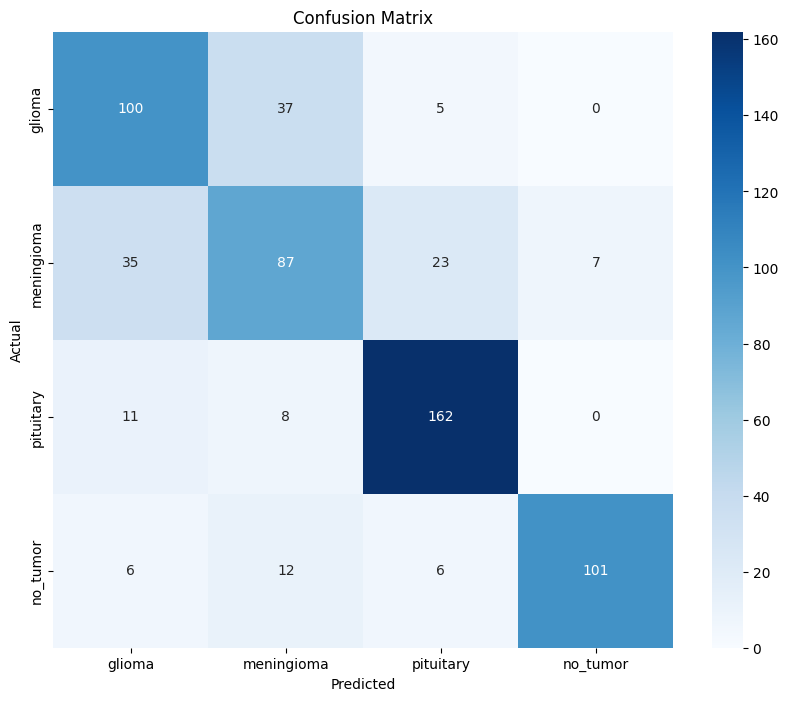

Classification Report:
              precision    recall  f1-score   support

      glioma       0.66      0.70      0.68       142
  meningioma       0.60      0.57      0.59       152
   pituitary       0.83      0.90      0.86       181
    no_tumor       0.94      0.81      0.87       125

    accuracy                           0.75       600
   macro avg       0.76      0.74      0.75       600
weighted avg       0.75      0.75      0.75       600

Segmentation Results:
  Dice Coefficient: 0.2108
  mIoU: 0.6016
  Pixel Accuracy: 0.9949

Classification Results:
  Accuracy: 0.7500
  Precision: 0.7529
  Recall: 0.7500
  F1 Score: 0.7498
Phase 1: Training segmentation head (classification frozen)


Seg Epoch 1/1: 100%|██████████| 263/263 [02:54<00:00,  1.50it/s]


Seg Epoch 1 - Loss: 2.0271, Dice: 0.0002
Phase 2: Training classification head (segmentation frozen)


Cls Epoch 1/1: 100%|██████████| 263/263 [01:02<00:00,  4.22it/s]


Cls Epoch 1 - Loss: 1.3191, Accuracy: 0.3809


Evaluating: 100%|██████████| 38/38 [00:09<00:00,  3.94it/s]


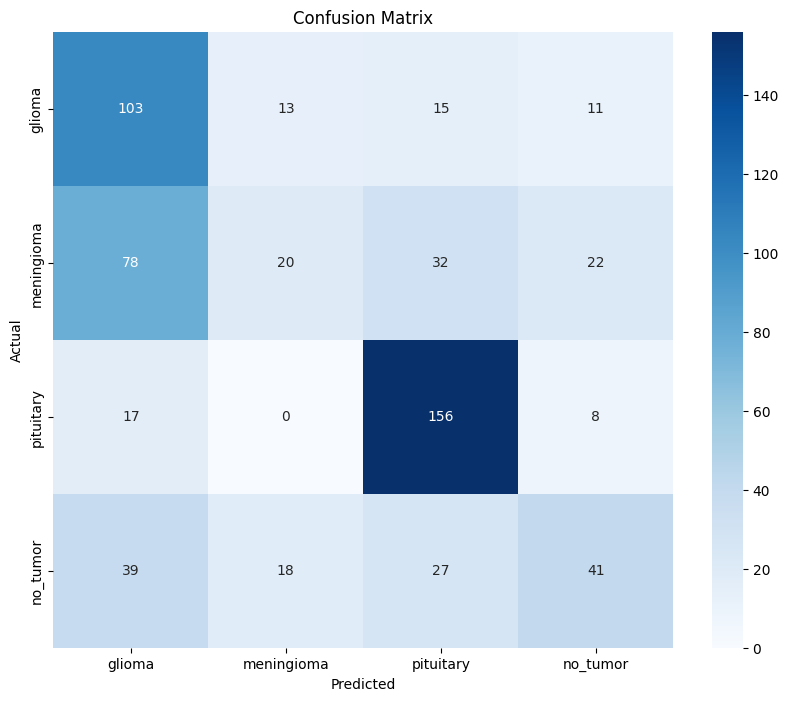

Classification Report:
              precision    recall  f1-score   support

      glioma       0.43      0.73      0.54       142
  meningioma       0.39      0.13      0.20       152
   pituitary       0.68      0.86      0.76       181
    no_tumor       0.50      0.33      0.40       125

    accuracy                           0.53       600
   macro avg       0.50      0.51      0.47       600
weighted avg       0.51      0.53      0.49       600

Segmentation Results:
  Dice Coefficient: 0.2108
  mIoU: 0.6016
  Pixel Accuracy: 0.9949

Classification Results:
  Accuracy: 0.5333
  Precision: 0.5110
  Recall: 0.5333
  F1 Score: 0.4901

Comparison of Joint vs Separate Training:
            Model  Dice Coefficient      IoU  Pixel Accuracy  Classification Accuracy  F1 Score
   Joint Training          0.210802 0.601605        0.994876                 0.750000  0.749789
Separate Training          0.210802 0.601605        0.994876                 0.533333  0.490085


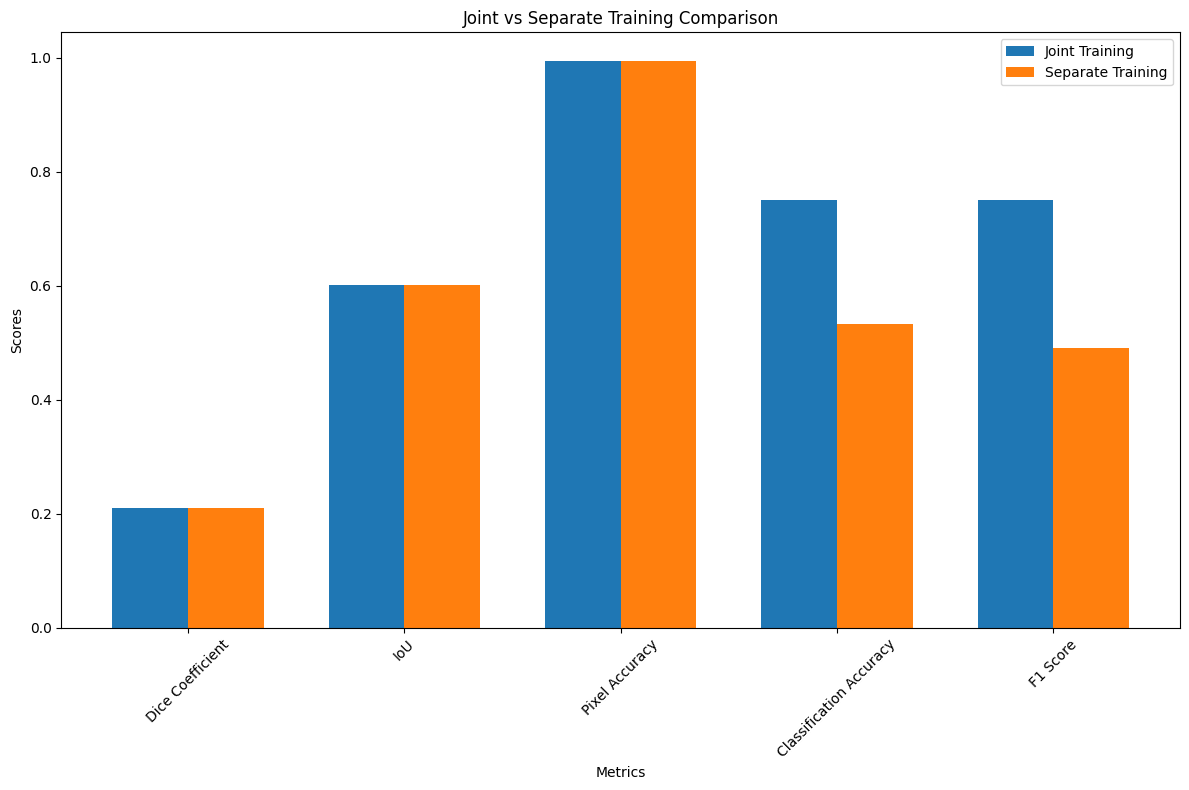

In [25]:
# Add this cell after your existing training code

def train_separate_heads(model, train_loader, val_loader, num_epochs=2, learning_rate=1e-3):
    """
    Train segmentation and classification heads separately
    """
    # Create a copy of the model to avoid modifying the original
    model_copy = UNet(n_channels=3, n_classes=2, n_classification_classes=4).to(device)
    model_copy.load_state_dict(model.state_dict())
    
    # Phase 1: Train only segmentation (freeze classification)
    print("Phase 1: Training segmentation head (classification frozen)")
    for name, param in model_copy.named_parameters():
        if 'classifier' in name:
            param.requires_grad = False
    
    # Use only segmentation loss
    criterion_seg = DiceLoss()
    optimizer_seg = optim.Adam(
        filter(lambda p: p.requires_grad, model_copy.parameters()), 
        lr=learning_rate, 
        weight_decay=1e-5
    )
    
    seg_history = {'loss': [], 'dice': []}
    
    for epoch in range(num_epochs // 2):
        model_copy.train()
        running_loss = 0.0
        running_dice = 0.0
        
        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Seg Epoch {epoch+1}/{num_epochs//2}")):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            
            optimizer_seg.zero_grad()
            
            seg_pred, _ = model_copy(images)
            loss = criterion_seg(seg_pred, masks.float())
            
            loss.backward()
            optimizer_seg.step()
            
            with torch.no_grad():
                seg_pred_binary = torch.argmax(seg_pred, dim=1)
                dice = calculate_dice_coefficient(seg_pred_binary.float(), masks.float())
            
            running_loss += loss.item()
            running_dice += dice
        
        seg_history['loss'].append(running_loss / len(train_loader))
        seg_history['dice'].append(running_dice / len(train_loader))
        
        print(f"Seg Epoch {epoch+1} - Loss: {seg_history['loss'][-1]:.4f}, Dice: {seg_history['dice'][-1]:.4f}")
    
    # Phase 2: Train only classification (freeze segmentation)
    print("Phase 2: Training classification head (segmentation frozen)")
    for name, param in model_copy.named_parameters():
        if 'classifier' in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    
    criterion_cls = nn.CrossEntropyLoss()
    optimizer_cls = optim.Adam(
        filter(lambda p: p.requires_grad, model_copy.parameters()), 
        lr=learning_rate, 
        weight_decay=1e-5
    )
    
    cls_history = {'loss': [], 'accuracy': []}
    
    for epoch in range(num_epochs // 2):
        model_copy.train()
        running_loss = 0.0
        running_acc = 0.0
        
        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Cls Epoch {epoch+1}/{num_epochs//2}")):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            
            optimizer_cls.zero_grad()
            
            _, cls_pred = model_copy(images)
            loss = criterion_cls(cls_pred, labels)
            
            loss.backward()
            optimizer_cls.step()
            
            with torch.no_grad():
                cls_pred_labels = torch.argmax(cls_pred, dim=1)
                acc = (cls_pred_labels == labels).float().mean().item()
            
            running_loss += loss.item()
            running_acc += acc
        
        cls_history['loss'].append(running_loss / len(train_loader))
        cls_history['accuracy'].append(running_acc / len(train_loader))
        
        print(f"Cls Epoch {epoch+1} - Loss: {cls_history['loss'][-1]:.4f}, Accuracy: {cls_history['accuracy'][-1]:.4f}")
    
    return model_copy, {'seg_history': seg_history, 'cls_history': cls_history}

# Compare joint vs separate training
print("="*60)
print("BONUS TASK 1: Comparing Joint vs Separate Training")
print("="*60)

# Evaluate the jointly trained model (already trained)
joint_results = evaluate_model(trained_unet, test_loader, device)

# Train with separate heads
separate_model, separate_history = train_separate_heads(
    trained_unet, train_loader, val_loader, num_epochs=2, learning_rate=1e-3
)

# Evaluate the separately trained model
separate_results = evaluate_model(separate_model, test_loader, device)

# Create comparison table
comparison_data = {
    'Model': ['Joint Training', 'Separate Training'],
    'Dice Coefficient': [joint_results.get('seg_dice', 0), separate_results.get('seg_dice', 0)],
    'IoU': [joint_results.get('seg_iou', 0), separate_results.get('seg_iou', 0)],
    'Pixel Accuracy': [joint_results.get('pixel_acc', 0), separate_results.get('pixel_acc', 0)],
    'Classification Accuracy': [joint_results.get('cls_accuracy', 0), separate_results.get('cls_accuracy', 0)],
    'F1 Score': [joint_results.get('cls_f1', 0), separate_results.get('cls_f1', 0)]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nComparison of Joint vs Separate Training:")
print(comparison_df.to_string(index=False))

# Plot comparison
metrics = ['Dice Coefficient', 'IoU', 'Pixel Accuracy', 'Classification Accuracy', 'F1 Score']
joint_values = [
    joint_results.get('seg_dice', 0), 
    joint_results.get('seg_iou', 0),
    joint_results.get('pixel_acc', 0), 
    joint_results.get('cls_accuracy', 0),
    joint_results.get('cls_f1', 0)
]
separate_values = [
    separate_results.get('seg_dice', 0), 
    separate_results.get('seg_iou', 0),
    separate_results.get('pixel_acc', 0), 
    separate_results.get('cls_accuracy', 0),
    separate_results.get('cls_f1', 0)
]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(x - width/2, joint_values, width, label='Joint Training')
ax.bar(x + width/2, separate_values, width, label='Separate Training')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Joint vs Separate Training Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

BONUS TASK 2: Different Classifier Architectures

Training U-Net with original classifier...


Epoch 1/5: 100%|██████████| 263/263 [01:03<00:00,  4.16it/s]


Epoch 1 - Loss: 1.1401, Accuracy: 0.5316


Epoch 2/5: 100%|██████████| 263/263 [01:02<00:00,  4.19it/s]


Epoch 2 - Loss: 1.0114, Accuracy: 0.5927


Epoch 3/5: 100%|██████████| 263/263 [01:02<00:00,  4.21it/s]


Epoch 3 - Loss: 1.0006, Accuracy: 0.5941


Epoch 4/5: 100%|██████████| 263/263 [01:03<00:00,  4.16it/s]


Epoch 4 - Loss: 0.9765, Accuracy: 0.5965


Epoch 5/5: 100%|██████████| 263/263 [01:03<00:00,  4.12it/s]


Epoch 5 - Loss: 0.9900, Accuracy: 0.5927


Evaluating: 100%|██████████| 38/38 [00:09<00:00,  3.93it/s]


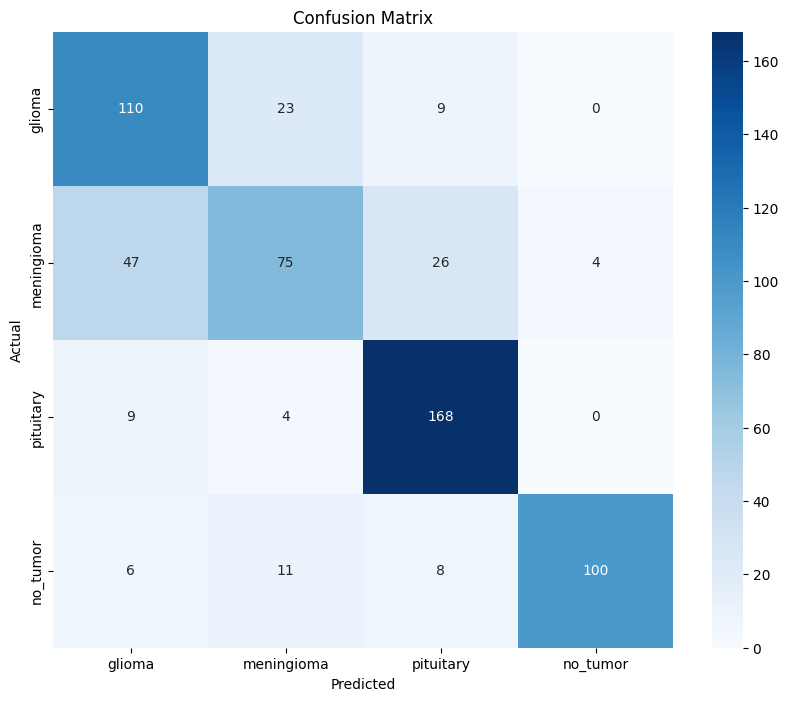

Classification Report:
              precision    recall  f1-score   support

      glioma       0.64      0.77      0.70       142
  meningioma       0.66      0.49      0.57       152
   pituitary       0.80      0.93      0.86       181
    no_tumor       0.96      0.80      0.87       125

    accuracy                           0.76       600
   macro avg       0.77      0.75      0.75       600
weighted avg       0.76      0.76      0.75       600

Segmentation Results:
  Dice Coefficient: 0.2108
  mIoU: 0.6016
  Pixel Accuracy: 0.9949

Classification Results:
  Accuracy: 0.7550
  Precision: 0.7600
  Recall: 0.7550
  F1 Score: 0.7497

Training U-Net with deep classifier...


Epoch 1/5: 100%|██████████| 263/263 [01:02<00:00,  4.19it/s]


Epoch 1 - Loss: 1.1615, Accuracy: 0.5112


Epoch 2/5: 100%|██████████| 263/263 [01:02<00:00,  4.22it/s]


Epoch 2 - Loss: 1.0201, Accuracy: 0.5732


Epoch 3/5: 100%|██████████| 263/263 [01:02<00:00,  4.23it/s]


Epoch 3 - Loss: 0.9873, Accuracy: 0.5924


Epoch 4/5: 100%|██████████| 263/263 [01:02<00:00,  4.23it/s]


Epoch 4 - Loss: 0.9670, Accuracy: 0.5939


Epoch 5/5: 100%|██████████| 263/263 [01:02<00:00,  4.21it/s]


Epoch 5 - Loss: 0.9603, Accuracy: 0.5965


Evaluating: 100%|██████████| 38/38 [00:09<00:00,  3.95it/s]


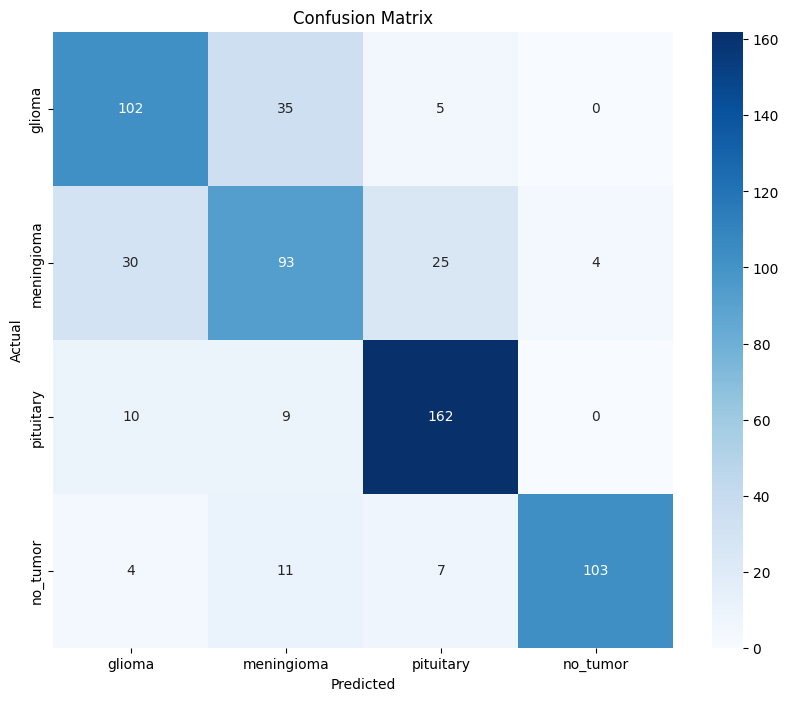

Classification Report:
              precision    recall  f1-score   support

      glioma       0.70      0.72      0.71       142
  meningioma       0.63      0.61      0.62       152
   pituitary       0.81      0.90      0.85       181
    no_tumor       0.96      0.82      0.89       125

    accuracy                           0.77       600
   macro avg       0.78      0.76      0.77       600
weighted avg       0.77      0.77      0.77       600

Segmentation Results:
  Dice Coefficient: 0.2108
  mIoU: 0.6016
  Pixel Accuracy: 0.9949

Classification Results:
  Accuracy: 0.7667
  Precision: 0.7707
  Recall: 0.7667
  F1 Score: 0.7669

Training U-Net with attention classifier...


Epoch 1/5: 100%|██████████| 263/263 [01:02<00:00,  4.21it/s]


Epoch 1 - Loss: 1.1958, Accuracy: 0.5157


Epoch 2/5: 100%|██████████| 263/263 [01:02<00:00,  4.24it/s]


Epoch 2 - Loss: 1.0395, Accuracy: 0.5839


Epoch 3/5: 100%|██████████| 263/263 [01:01<00:00,  4.28it/s]


Epoch 3 - Loss: 1.0078, Accuracy: 0.5872


Epoch 4/5: 100%|██████████| 263/263 [01:01<00:00,  4.26it/s]


Epoch 4 - Loss: 1.0042, Accuracy: 0.5822


Epoch 5/5: 100%|██████████| 263/263 [01:01<00:00,  4.26it/s]


Epoch 5 - Loss: 0.9823, Accuracy: 0.5920


Evaluating: 100%|██████████| 38/38 [00:09<00:00,  3.92it/s]


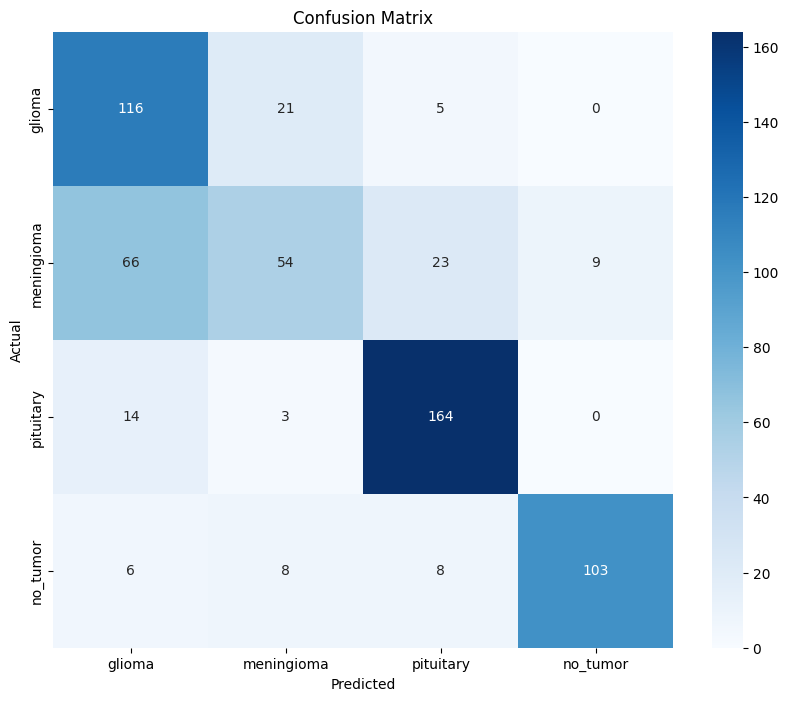

Classification Report:
              precision    recall  f1-score   support

      glioma       0.57      0.82      0.67       142
  meningioma       0.63      0.36      0.45       152
   pituitary       0.82      0.91      0.86       181
    no_tumor       0.92      0.82      0.87       125

    accuracy                           0.73       600
   macro avg       0.74      0.73      0.71       600
weighted avg       0.73      0.73      0.72       600

Segmentation Results:
  Dice Coefficient: 0.2108
  mIoU: 0.6016
  Pixel Accuracy: 0.9949

Classification Results:
  Accuracy: 0.7283
  Precision: 0.7339
  Recall: 0.7283
  F1 Score: 0.7154

Comparison of Different Classifier Architectures:
Classifier Type  Dice Coefficient      IoU  Classification Accuracy  F1 Score
       original          0.210802 0.601605                 0.755000  0.749736
           deep          0.210802 0.601605                 0.766667  0.766902
      attention          0.210802 0.601605                 0.728333 

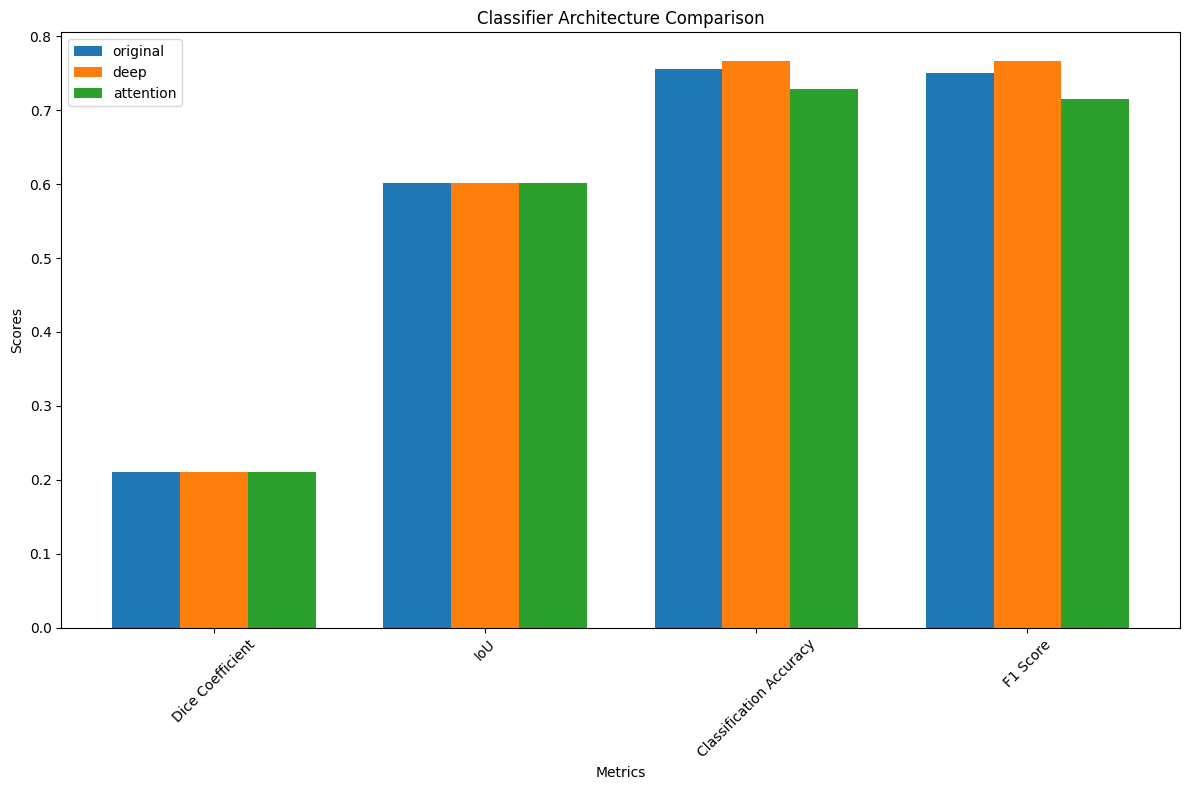

In [26]:
# Add this cell after the previous one

print("="*60)
print("BONUS TASK 2: Different Classifier Architectures")
print("="*60)

# Define different classifier architectures
class UNetWithDeepClassifier(UNet):
    def __init__(self, n_channels=3, n_classes=2, n_classification_classes=4, bilinear=True):
        super(UNetWithDeepClassifier, self).__init__(n_channels, n_classes, n_classification_classes, bilinear)
        
        # Replace the classifier with a deeper one
        factor = 2 if bilinear else 1
        self.classifier = nn.Sequential(
            nn.Linear(1024 // factor, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, n_classification_classes)
        )

class UNetWithAttentionClassifier(UNet):
    def __init__(self, n_channels=3, n_classes=2, n_classification_classes=4, bilinear=True):
        super(UNetWithAttentionClassifier, self).__init__(n_channels, n_classes, n_classification_classes, bilinear)
        
        # Add attention mechanism to classifier
        factor = 2 if bilinear else 1
        self.attention = nn.Sequential(
            nn.Linear(1024 // factor, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1024 // factor),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024 // factor, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, n_classification_classes)
        )
    
    def forward(self, x):
        # Standard U-Net forward pass
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Classification with attention
        classification_features = self.global_avg_pool(x5)
        classification_features = classification_features.view(classification_features.size(0), -1)
        
        # Apply attention
        attention_weights = self.attention(classification_features)
        attended_features = classification_features * attention_weights
        
        classification_output = self.classifier(attended_features)
        
        # Segmentation decoder
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        segmentation_output = self.outc(x)
        
        return segmentation_output, classification_output

# Train and compare different classifier architectures
classifier_types = ['original', 'deep', 'attention']
classifier_results = {}

for cls_type in classifier_types:
    print(f"\nTraining U-Net with {cls_type} classifier...")
    
    if cls_type == 'original':
        model = UNet(n_channels=3, n_classes=2, n_classification_classes=4).to(device)
    elif cls_type == 'deep':
        model = UNetWithDeepClassifier(n_channels=3, n_classes=2, n_classification_classes=4).to(device)
    elif cls_type == 'attention':
        model = UNetWithAttentionClassifier(n_channels=3, n_classes=2, n_classification_classes=4).to(device)
    
    # Transfer learning: copy the encoder and decoder weights from the pre-trained model
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in trained_unet.state_dict().items() 
                      if k in model_dict and not k.startswith('classifier')}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    
    # Freeze the segmentation parts and only train the classifier
    for name, param in model.named_parameters():
        if not name.startswith('classifier'):
            param.requires_grad = False
    
    # Train only the classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    
    for epoch in range(5):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        
        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/5")):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            
            _, cls_pred = model(images)
            loss = criterion(cls_pred, labels)
            
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                cls_pred_labels = torch.argmax(cls_pred, dim=1)
                acc = (cls_pred_labels == labels).float().mean().item()
            
            running_loss += loss.item()
            running_acc += acc
        
        print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f}, Accuracy: {running_acc/len(train_loader):.4f}")
    
    # Evaluate
    results = evaluate_model(model, test_loader, device)
    classifier_results[cls_type] = results

# Create comparison table
cls_comparison_data = {
    'Classifier Type': classifier_types,
    'Dice Coefficient': [classifier_results[t].get('seg_dice', 0) for t in classifier_types],
    'IoU': [classifier_results[t].get('seg_iou', 0) for t in classifier_types],
    'Classification Accuracy': [classifier_results[t].get('cls_accuracy', 0) for t in classifier_types],
    'F1 Score': [classifier_results[t].get('cls_f1', 0) for t in classifier_types]
}

cls_comparison_df = pd.DataFrame(cls_comparison_data)
print("\nComparison of Different Classifier Architectures:")
print(cls_comparison_df.to_string(index=False))

# Plot comparison
metrics = ['Dice Coefficient', 'IoU', 'Classification Accuracy', 'F1 Score']
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 8))
for i, cls_type in enumerate(classifier_types):
    values = [
        classifier_results[cls_type].get('seg_dice', 0),
        classifier_results[cls_type].get('seg_iou', 0),
        classifier_results[cls_type].get('cls_accuracy', 0),
        classifier_results[cls_type].get('cls_f1', 0)
    ]
    ax.bar(x + (i-1)*width, values, width, label=cls_type)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Classifier Architecture Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

BONUS TASK 3: Hyperparameter Tuning

Testing: lr=0.001, optimizer=adam, batch_size=8
Results - Loss: 1.8164, Dice: 0.0028, Accuracy: 0.3718

Testing: lr=0.001, optimizer=adam, batch_size=16
Results - Loss: 2.0189, Dice: 0.0044, Accuracy: 0.2679

Testing: lr=0.001, optimizer=adam, batch_size=32
Results - Loss: 2.0294, Dice: 0.0023, Accuracy: 0.2500

Testing: lr=0.001, optimizer=sgd, batch_size=8
Results - Loss: 1.9724, Dice: 0.0047, Accuracy: 0.3365

Testing: lr=0.001, optimizer=sgd, batch_size=16
Results - Loss: 2.2114, Dice: 0.0056, Accuracy: 0.3006

Testing: lr=0.001, optimizer=sgd, batch_size=32
Results - Loss: 2.1063, Dice: 0.0058, Accuracy: 0.2448

Testing: lr=0.001, optimizer=rmsprop, batch_size=8
Results - Loss: 1.8136, Dice: 0.0016, Accuracy: 0.2981

Testing: lr=0.001, optimizer=rmsprop, batch_size=16
Results - Loss: 2.2513, Dice: 0.0036, Accuracy: 0.2470

Testing: lr=0.001, optimizer=rmsprop, batch_size=32
Results - Loss: 2.1746, Dice: 0.0016, Accuracy: 0.2656

Testing: lr=0.0

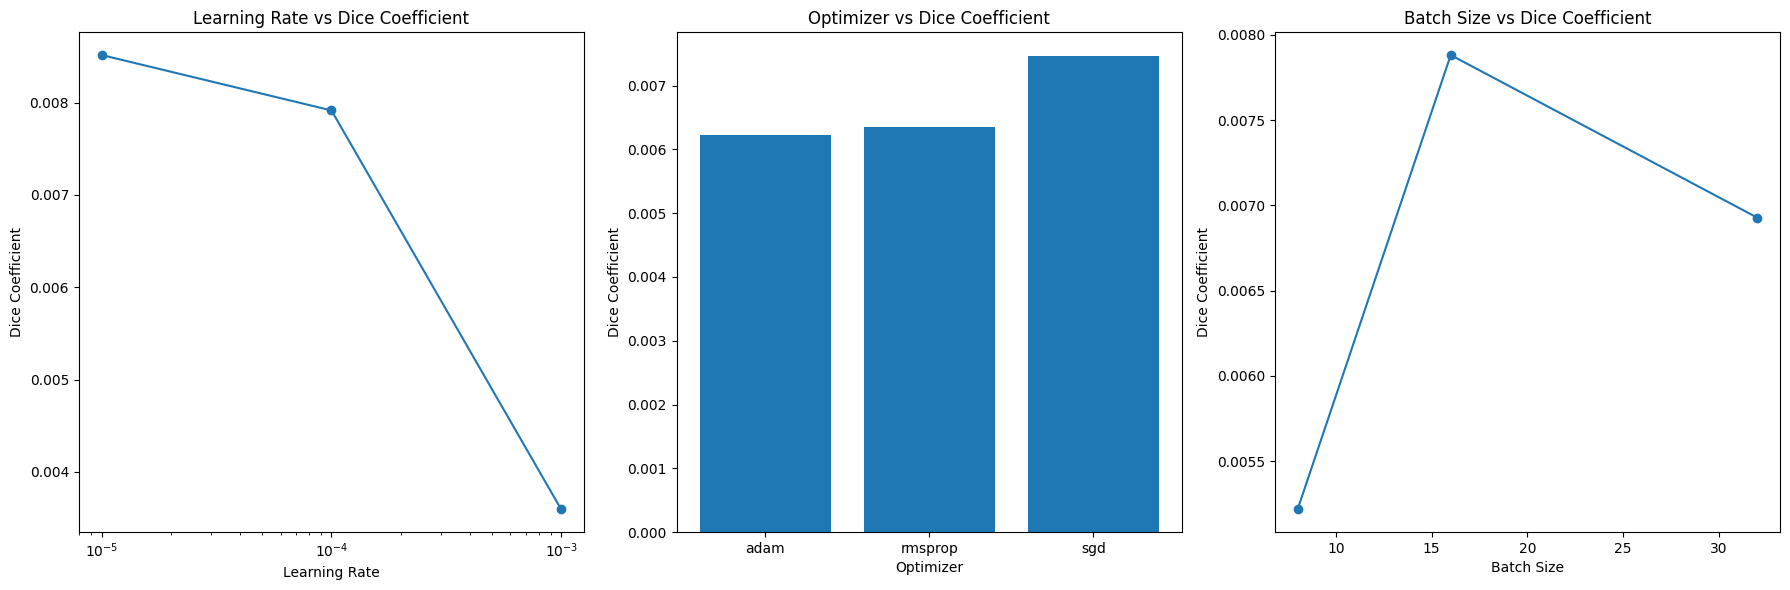

In [28]:
# Add this cell after the previous one

print("="*60)
print("BONUS TASK 3: Hyperparameter Tuning")
print("="*60)

# Define hyperparameters to try
learning_rates = [1e-3, 1e-4, 1e-5]
optimizers_list = ['adam', 'sgd', 'rmsprop']
batch_sizes = [8, 16, 32]

# We'll use a smaller subset of data for hyperparameter tuning to save time
subset_indices = torch.randperm(len(train_loader.dataset))[:100]
subset_loader = DataLoader(
    Subset(train_loader.dataset, subset_indices),
    batch_size=BATCH_SIZE,
    shuffle=True
)

hyperparameter_results = []

for lr in learning_rates:
    for opt_name in optimizers_list:
        for batch_size in batch_sizes:
            print(f"\nTesting: lr={lr}, optimizer={opt_name}, batch_size={batch_size}")
            
            # Create model
            model = UNet(n_channels=3, n_classes=2, n_classification_classes=4).to(device)
            
            # Create optimizer
            if opt_name == 'adam':
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
            elif opt_name == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
            elif opt_name == 'rmsprop':
                optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-5)
            
            criterion = CombinedLoss(seg_weight=1.0, cls_weight=1.0)
            
            # Create data loader with current batch size
            current_loader = DataLoader(
                Subset(train_loader.dataset, subset_indices),
                batch_size=batch_size,
                shuffle=True
            )
            
            # Train for a few epochs
            model.train()
            running_loss = 0.0
            running_dice = 0.0
            running_acc = 0.0
            
            for epoch in range(3):  # Short training for tuning
                for batch_idx, batch in enumerate(current_loader):
                    images = batch['image'].to(device)
                    masks = batch['mask'].to(device)
                    labels = batch['label'].to(device)
                    
                    optimizer.zero_grad()
                    
                    seg_pred, cls_pred = model(images)
                    total_loss, seg_loss, cls_loss = criterion(seg_pred, cls_pred, masks, labels)
                    
                    total_loss.backward()
                    optimizer.step()
                    
                    with torch.no_grad():
                        seg_pred_binary = torch.argmax(seg_pred, dim=1)
                        dice = calculate_dice_coefficient(seg_pred_binary.float(), masks.float())
                        
                        cls_pred_labels = torch.argmax(cls_pred, dim=1)
                        acc = (cls_pred_labels == labels).float().mean().item()
                    
                    running_loss += total_loss.item()
                    running_dice += dice
                    running_acc += acc
            
            avg_loss = running_loss / (3 * len(current_loader))
            avg_dice = running_dice / (3 * len(current_loader))
            avg_acc = running_acc / (3 * len(current_loader))
            
            hyperparameter_results.append({
                'learning_rate': lr,
                'optimizer': opt_name,
                'batch_size': batch_size,
                'loss': avg_loss,
                'dice': avg_dice,
                'accuracy': avg_acc
            })
            
            print(f"Results - Loss: {avg_loss:.4f}, Dice: {avg_dice:.4f}, Accuracy: {avg_acc:.4f}")

# Convert to DataFrame
hyperparameter_df = pd.DataFrame(hyperparameter_results)

# Find best parameters based on different metrics
best_loss = hyperparameter_df.loc[hyperparameter_df['loss'].idxmin()]
best_dice = hyperparameter_df.loc[hyperparameter_df['dice'].idxmax()]
best_accuracy = hyperparameter_df.loc[hyperparameter_df['accuracy'].idxmax()]

print("\nBest parameters based on validation loss:")
print(best_loss)

print("\nBest parameters based on validation dice coefficient:")
print(best_dice)

print("\nBest parameters based on validation accuracy:")
print(best_accuracy)

# Visualize hyperparameter results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Learning rate comparison - only use numeric columns
lr_groups = hyperparameter_df.groupby('learning_rate')[['loss', 'dice', 'accuracy']].mean().reset_index()
axes[0].plot(lr_groups['learning_rate'], lr_groups['dice'], marker='o')
axes[0].set_xscale('log')
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Dice Coefficient')
axes[0].set_title('Learning Rate vs Dice Coefficient')

# Optimizer comparison - only use numeric columns
opt_groups = hyperparameter_df.groupby('optimizer')[['loss', 'dice', 'accuracy']].mean().reset_index()
axes[1].bar(opt_groups['optimizer'], opt_groups['dice'])
axes[1].set_xlabel('Optimizer')
axes[1].set_ylabel('Dice Coefficient')
axes[1].set_title('Optimizer vs Dice Coefficient')

# Batch size comparison - only use numeric columns
bs_groups = hyperparameter_df.groupby('batch_size')[['loss', 'dice', 'accuracy']].mean().reset_index()
axes[2].plot(bs_groups['batch_size'], bs_groups['dice'], marker='o')
axes[2].set_xlabel('Batch Size')
axes[2].set_ylabel('Dice Coefficient')
axes[2].set_title('Batch Size vs Dice Coefficient')

plt.tight_layout()
plt.show()

In [42]:
# Add this cell after the previous one

print("="*60)
print("BONUS TASK 4: EfficientDet's BiFPN Implementation")
print("="*60)

# Implement BiFPN blocks
class BiFPNBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BiFPNBlock, self).__init__()
        self.conv6_up = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv4_up = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv3_up = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        
        self.conv6_down = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv5_down = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv4_down = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv3_down = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        self.epsilon = 1e-4
        
    def forward(self, inputs):
        # Unpack inputs
        c3, c4, c5 = inputs
        
        # Top-down pathway
        p6_up = self.conv6_up(c5)
        p5_up = F.interpolate(p6_up, scale_factor=2) + self.conv5_up(c4)
        p4_up = F.interpolate(p5_up, scale_factor=2) + self.conv4_up(c3)
        
        # Bottom-up pathway
        p3_down = self.conv3_down(p4_up)
        p4_down = self.conv4_down(p3_down + F.avg_pool2d(p5_up, kernel_size=2))
        p5_down = self.conv5_down(p4_down + F.avg_pool2d(p6_up, kernel_size=2))
        p6_down = self.conv6_down(p5_down)
        
        return p3_down, p4_down, p5_down, p6_down

class UNetWithBiFPN(UNet):
    def __init__(self, n_channels=3, n_classes=2, n_classification_classes=4, bilinear=True):
        super(UNetWithBiFPN, self).__init__(n_channels, n_classes, n_classification_classes, bilinear)
        
        # Replace the standard decoder with BiFPN
        self.bifpn = BiFPNBlock(512, 256)
        
        # Modify the upsampling layers to work with BiFPN
        self.up1 = Up(1024, 512, bilinear)
        self.up2 = Up(512, 256, bilinear)
        self.up3 = Up(256, 128, bilinear)
        self.up4 = Up(128, 64, bilinear)
        
    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Classification head
        classification_features = self.global_avg_pool(x5)
        classification_features = classification_features.view(classification_features.size(0), -1)
        classification_output = self.classifier(classification_features)
        
        # BiFPN decoder
        p3, p4, p5, p6 = self.bifpn([x3, x4, x5])
        
        # Final upsampling and segmentation
        x = self.up1(p6, p5)
        x = self.up2(x, p4)
        x = self.up3(x, p3)
        x = self.up4(x, x2)
        
        segmentation_output = self.outc(x)
        
        return segmentation_output, classification_output

# Train and evaluate BiFPN model
print("Training U-Net with BiFPN decoder...")
bifpn_model = UNetWithBiFPN(n_channels=3, n_classes=2, n_classification_classes=4).to(device)

# Use transfer learning for the encoder
model_dict = bifpn_model.state_dict()
pretrained_dict = {k: v for k, v in trained_unet.state_dict().items() 
                  if k in model_dict and not any(x in k for x in ['bifpn', 'up1', 'up2', 'up3', 'up4'])}
model_dict.update(pretrained_dict)
bifpn_model.load_state_dict(model_dict)

# Train the BiFPN model
trained_bifpn, bifpn_history = train_model(
    bifpn_model, train_loader, val_loader, num_epochs=2, learning_rate=1e-3
)

# Evaluate
bifpn_results = evaluate_model(trained_bifpn, test_loader, device)

# Compare with original U-Net
bifpn_comparison_data = {
    'Model': ['Standard U-Net', 'U-Net with BiFPN'],
    'Dice Coefficient': [joint_results.get('seg_dice', 0), bifpn_results.get('seg_dice', 0)],
    'IoU': [joint_results.get('seg_iou', 0), bifpn_results.get('seg_iou', 0)],
    'Pixel Accuracy': [joint_results.get('pixel_acc', 0), bifpn_results.get('pixel_acc', 0)],
    'Classification Accuracy': [joint_results.get('cls_accuracy', 0), bifpn_results.get('cls_accuracy', 0)],
    'F1 Score': [joint_results.get('cls_f1', 0), bifpn_results.get('cls_f1', 0)]
}

bifpn_comparison_df = pd.DataFrame(bifpn_comparison_data)
print("\nComparison of Standard U-Net vs U-Net with BiFPN:")
print(bifpn_comparison_df.to_string(index=False))

# Plot comparison
metrics = ['Dice Coefficient', 'IoU', 'Pixel Accuracy', 'Classification Accuracy', 'F1 Score']
standard_values = [
    joint_results.get('seg_dice', 0),
    joint_results.get('seg_iou', 0),
    joint_results.get('pixel_acc', 0),
    joint_results.get('cls_accuracy', 0),
    joint_results.get('cls_f1', 0)
]
bifpn_values = [
    bifpn_results.get('seg_dice', 0),
    bifpn_results.get('seg_iou', 0),
    bifpn_results.get('pixel_acc', 0),
    bifpn_results.get('cls_accuracy', 0),
    bifpn_results.get('cls_f1', 0)
]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(x - width/2, standard_values, width, label='Standard U-Net')
ax.bar(x + width/2, bifpn_values, width, label='U-Net with BiFPN')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Standard U-Net vs U-Net with BiFPN')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

# Save the BiFPN model
try:
    torch.save(trained_bifpn.state_dict(), 'bifpn_unet_brain_tumor_model.pth')
    print("BiFPN U-Net model saved successfully!")
except Exception as e:
    print(f"Error saving BiFPN model: {e}")

BONUS TASK 4: EfficientDet's BiFPN Implementation
Training U-Net with BiFPN decoder...
Training UNetWithBiFPN for 2 epochs...

Epoch 1/2
Learning Rate: 0.001000


Training:   0%|          | 0/263 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 228.12 MiB is free. Process 3911 has 14.52 GiB memory in use. Of the allocated memory 14.27 GiB is allocated by PyTorch, and 112.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)